EMA TM351-17J <br>
A7996195 <br>
Patryk Jakubik <br>
<br>
Run and tested on Jupyter Notebook 5.4.0 (Anaconda Navigator 1.8.5) 27.05.2018 <br>
<br>
v1.3 <br>

--- please use links to major parts of the analysis and "top" link to go back to Table of contents ---

# Table of contents<a name="top"></a>

1. [Reading data](#introduction)
2. [Helper Functions and static variables](#helper_functions)
3. [Cleaning data for Question 1 (1279924960.csv file)](#Cleaning_data_from_1279924960)
3. [Shape data from file init_127994960.csv](#shape_data_1279924960)

5. [Analyse data for Question 1](#analyse_q1)
    1. [Men group (Int count)](#dist_m_count)
    2. [Women group (Int count)](#dist_w_count)
    3. [Men group (percentage)](#men_gr_pie)
    4. [Women group (percentage)](#women_gr_pie)
    5. [Statistics for all age groups (men and women)](#stats_m_w)
    6. [Differences between number of men and women working at the specific occupation type in each age group](#age_cat_diff)
      
6. [Cleaning data for Question 2](#cleanup_q2)
    12. [Post Code cleanup](#post_code_cleanup)
    13. [KS2 Dataset cleanup](#ks2_cleanup)
    14. [Merging Data Frames](#marge_ks2_occgr)
    15. [Conversion to percentage (merged data frame)](#perc_conv_la)
      
7. [Analyse data for Question 2](#analyse_q2)
    17. [Analysis of reading scores for H_MAPO in all ages](#reading_all_h_mapo)
    18. [Reading in group age 16-24](#Reading_MF16-24All)
    19. [Reading in group age 25-49](#Reading_MF25-49All)
    20. [Reading in group age 50-64](#Reading_MF50-64All)
    22. [Writing in group age 16-24](#Writing_MF16-24All)
    23. [Writing in group age 25-49](#Writing_MF25-49All)
    23. [Writing in group age 50-64](#Writing_MF50-64All)
    24. [Maths in group age 16-24](#Maths_MF16-24All)
    25. [Maths in group age 25-49](#Maths_MF25-49All)
    26. [Maths in group age 50-64](#Maths_MF50-64All)

In [394]:
import pandas as pd
import numpy as np

import re

import glob

import matplotlib.pyplot as plt

import seaborn as sns

import datetime

pd.options.mode.chained_assignment = None

from sklearn import cluster
from sklearn.metrics import silhouette_samples
#from pandas.tools.plotting import table

plt.rcParams["figure.figsize"] = [12,8]

In [395]:
# init runtime
import time
startT = time.time()

### Reading data <a name="introduction"></a>
[top](#top)

In [396]:
# using error_bad_lines=False will cause the offending lines to be skipped
# https://stackoverflow.com/questions/18039057/python-pandas-error-tokenizing-data
#low_memory=False

m_df = pd.read_csv('data/Performancetables/1279924960.csv', low_memory=False)
m_df.head()

#print(m_df.iloc[1044])

,local authority: district / unitary (prior to April 2015),mnemonic,All categories: NS-SeC,"1. Higher managerial, administrative and professional occupations","2. Lower managerial, administrative and professional occupations",3. Intermediate occupations,4. Small employers and own account workers,5. Lower supervisory and technical occupations,6. Semi-routine occupations,7. Routine occupations,8. Never worked and long-term unemployed,Not classified
0,DC6206EW - NS-SeC by ethnic group by sex by age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ONS Crown Copyright Reserved [from Nomis on 24...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Population :,All usual residents aged 16 and over,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Units :,Persons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Date :,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Helper functions and static variables <a name="helper_functions"></a>
[top](#top)

In [397]:
# pre-define variables to carryout some investigation below

fst_col_name = 'local authority: district / unitary (prior to April 2015)'
la_ftr = ['Cambridge','East Cambridgeshire', 'Fenland', 'Huntingdonshire', 'South Cambridgeshire']

In [398]:
# save data frame to csv file

# Args:
#     prefix (String):
#     df (DataFrame):

# Returns:
    # Void:

def saveDataFrame(prefix, df):
    s = str(datetime.datetime.now())
    s = s.replace("-", "")
    s = s.replace(" ", "")
    s = s.replace(":", "")
    s = s.replace(".", "")
    s = s[:-6]
    df.to_csv(prefix + s + '.csv')

In [399]:
# check counts of redundent descriptions and delete them if the count is the same

# Args:
#     x (Int):
#     y (Int):
#     z (Int):

# Returns:
    # Boolean:

def checkCounts(x, y, z):
    if (x == y):
        if (y == z):
            return True
    else:
        return False

In [400]:
# convert each post code to the correct format e.g "WWDD DWW" or "WWD DWW"

# Args:
#     ps_str (String): Post code

# Returns:
    # String: Post Code

def formatPostCode(ps_str):
    if(ps_str.find(" ") >= 0):
        s = removeSpace(ps_str)
        ps_str = convertToPC(s)
    else:
        ps_str = convertToPC(ps_str)
    #print(ps_str)
    return ps_str
        
# helper method to remove white space
def removeSpace(ws_str):
    o_str = ""
    for i in ws_str:
        if(i != " "):
            o_str = o_str + i
    #print(o_str)
    return o_str

# helper method to convert the string to post code
def convertToPC(tc_str):
    ps_l = len(tc_str)-3
    ps_pe = tc_str[ps_l:]
    ps_pm = ' '
    ps_ps = tc_str[:ps_l]
    return ps_ps + ps_pm + ps_pe

In [401]:
# function that removes rows with redundent/dirty values

# Args:
#     col_list (List): list of columns that will have the cleaning applied
#     df (DataFrame): Data frame containing data for the cleaning
#     clean_list (List): list of values that will be removed along with the rows they are in

# Returns:
    # DataFrame: Cleaned DataFrame

def cleanCols(col_list, clean_list, df):
    del_report = ""
    dfc = df.copy()
    for cn in col_list:
        # check column count, then fill nans with 999.999
        cso = len(dfc[cn])
        dfc[cn].fillna(999.999, inplace=True)

        # remove rows if there is 999.999 value in the column 
        dfc = dfc.drop(dfc[dfc[cn] == 999.999].index)

        dfc[cn] = dfc[cn].replace(clean_list, 999.999)

        # remove rows if there is 999.999 value in the column and check deletion count
        dfc = dfc.drop(dfc[dfc[cn] == 999.999].index)
        csf = cso - len(dfc[cn])
        
        # update report
        del_report = del_report + cn + ': ' + str(csf) + ' rows deleted ' + '\n'
    print(del_report)
    return dfc

In [402]:
# loop through a list of names n and create len(n) copies of the first column

# adding a copy of an existing column and renaming it this way is less efficient, but it allows
# to run the cell as many times as you like and the result will be always the same

# Args:
#     col_names (List): names of columns for the cleaning
#     df (DataFrame): Data frame containing data for the cleaning

# Returns:
    # DataFrame: Cleaned DataFrame

def addNewColumn(col_names, df):
    m_df = df
    for i in col_names:
        m_df[i] = m_df.iloc[:,1]
        ecc = m_df[i]
        m_df.drop(labels=[i], axis=1, inplace=True)
        m_df.insert(len(m_df.columns), i, ecc)
    return m_df


In [403]:
# a function that filters data frame (parameter df) in "Sex", "Age" and "Ethnic" columns (concatenated to SAE)
# by specyfying filter values in the filter list (parameter fl) and column where the filetr is applied
# the function generates short report showing how many rows were removed filtered

# Args:
#   df (DataFrame):
#   fl (List): list of String values used to filter DataFrame
#   cn (String): name of the the column where filetr is applied

# Returns:
    # DataFrame:

def filterGroups(df, fl, cn):
    m_df = df
    bf = len(m_df[cn])
    m_df = m_df.loc[m_df[cn].isin(fl)]
    af = len(m_df[cn])
    print(af, ' rows filtered out of ', bf)
    return m_df

In [404]:
# function to build a cluster programatically

# Args:
#   df (DataFrame): Data Frame for the clustering
#   cl_num (Int): number of the required clusters

# Returns:
    # Void:


def buildCluster(df, cl_num, x, y):
    cl_cols = ['sienna', 'darkslateblue', 'olivedrab', 'darkturquoise', 'slategray', 'darkorchid', 'coral', 'tomato']
    lbs = ['Cl_A', 'Cl_B', 'Cl_C', 'Cl_D', 'Cl_E', 'Cl_F', 'Cl_G', 'Cl_H']
    if(cl_num <= 8):
        for i in range(cl_num):
            plt.scatter(df[x][assignedClusters_clust.labels_== cl_num],
            df[y][assignedClusters_clust.labels_== cl_num],
            color=cl_cols[i], marker='o', label=lbs[i])
    
    # Plot each of the centroids:
    for (cx, cy) in assignedClusters_clust.cluster_centers_:
        plt.plot(cx, cy, color='r', marker='x', mew=2)

    plt.legend()


    plt.xlabel('READPROG')
    plt.ylabel('H_MAPO')

    plt.title('MF16-24All')

    plt.plot([-3,3],[0.0648,0.0648], "r--")
    plt.plot([0.06,0.06],[0.0,0.3], "r--")
    plt.show()

## Cleaning data for the question (1279924960.csv file) <a name="Cleaning_data_from_1279924960"></a>
The file contains Local authorities and different types of occupations ranging from Higher managerial to Unemployed with a number of people working in the particular occupation type.
[top](#top)

In [405]:
# removing blank rows or rows with blank cell in the first column

m_df.iloc[:,0].fillna('_999.999', inplace=True)
m_df = m_df.loc[~m_df.iloc[:,0].str.contains('_999.999')]

In [406]:
# At this point I save the data frame to a csv file in order to check whether the file looks as expected...
#saveDataFrame('remRow', m_df)

# ...then I print part of the data frame where the blank rows were present before the deletion
m_df.iloc[1047:1056,0:]

,local authority: district / unitary (prior to April 2015),mnemonic,All categories: NS-SeC,"1. Higher managerial, administrative and professional occupations","2. Lower managerial, administrative and professional occupations",3. Intermediate occupations,4. Small employers and own account workers,5. Lower supervisory and technical occupations,6. Semi-routine occupations,7. Routine occupations,8. Never worked and long-term unemployed,Not classified
1047,Caerphilly,W06000018,718,35,110,84,43,68,91,121,97,69
1048,Blaenau Gwent,W06000019,267,9,36,9,11,23,54,49,44,32
1049,Torfaen,W06000020,360,20,64,35,23,29,53,46,28,62
1050,Monmouthshire,W06000021,345,36,64,30,29,19,52,38,27,50
1051,Newport,W06000022,1562,86,205,161,70,86,228,193,234,299
1067,DC6206EW - NS-SeC by ethnic group by sex by age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1068,ONS Crown Copyright Reserved [from Nomis on 24...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1069,Population :,All usual residents aged 16 and over,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1070,Units :,Persons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pre-cleaning in excel showed that 'Population:' equals "All usual residents aged 16 and over" for all groups in the 'mnemonic' table, so this selection can be deleted. The same applies to "Units : Persons" and "Date : 2011", which are the same in all groups, so they also will be deleted from the dataset. However, I will perform further checks below and then delete if redundent descriptions.

In [407]:
# remove any row that has a missing data in the first column (empty gaps between groups)
m_df = m_df[pd.notnull(m_df[fst_col_name])]

print(m_df.iloc[1054])

local authority: district / unitary (prior to April 2015)                                    Population :
mnemonic                                                             All usual residents aged 16 and over
All categories: NS-SeC                                                                                NaN
1. Higher managerial, administrative and professional occupations                                     NaN
2. Lower managerial, administrative and professional occupations                                      NaN
3. Intermediate occupations                                                                           NaN
4. Small employers and own account workers                                                            NaN
5. Lower supervisory and technical occupations                                                        NaN
6. Semi-routine occupations                                                                           NaN
7. Routine occupations                        

#### Helper function for checking counts of redundent descriptions and deleting them if the count is the same

In [408]:
# check if 'Population:' count is the same as 'All usual residents aged 16 and over' in the 'mnemonic' column
# and compare both counts with a count of 'Not Classified' - delete description if count is the same.

loc_auth_cp = m_df[fst_col_name].str.contains('Population :').sum()
all_us_cp = m_df['mnemonic'].str.contains('All usual residents aged 16 and over').sum()
not_class_cp = m_df['Not classified'].str.contains('Not classified').sum()

print(checkCounts(loc_auth_cp, all_us_cp, not_class_cp))

None


In [409]:
# delete (filter out) all rows with 'Population :' in the first column.

m_df = m_df.loc[~m_df[fst_col_name].str.contains('Population :')]
m_df[fst_col_name].str.contains('Population :').sum()

0

In [410]:
# check if 'Units    :' count is the same as 'Persons' in the 'mnemonic' column
# and compare both counts with a count of 'Not Classified' - delete description if count is the same.

loc_auth_cu = m_df[fst_col_name].str.contains('Units      :').sum()
all_us_cu = m_df['mnemonic'].str.contains('Persons').sum()
not_class_cu = m_df['Not classified'].str.contains('Not classified').sum()

print(checkCounts(loc_auth_cu, all_us_cu, not_class_cu))

None


In [411]:
# delete (filter out) all rows with 'Units  :' in the first column.

m_df = m_df.loc[~m_df[fst_col_name].str.contains('Units      :')]
m_df[fst_col_name].str.contains('Persons').sum()

0

In [412]:
# check if 'Date    :' count is the same as '2011' in the 'mnemonic' column
# and compare both counts with a count of 'Not Classified' - delete description if count is the same.

loc_auth_cd = m_df[fst_col_name].str.contains('Date       :').sum()
all_us_cd = m_df['mnemonic'].str.contains('2011').sum()
not_class_cd = m_df['Not classified'].str.contains('Not classified').sum()

print(checkCounts(loc_auth_cd, all_us_cd, not_class_cd))

None


In [413]:
# delete (filter out) all rows with 'Units  :' in the first column.

m_df = m_df.loc[~m_df[fst_col_name].str.contains('Date       :')]
m_df[fst_col_name].str.contains('2011').sum()

0

Delete two rows which hold data that will not be used for analysis

In [414]:
# check programatically whether the number of specified strings for deletion
# agree with the number of files in 'Not classified' column

# bracket [] is treted as a part of regular expression so it has to be escaped
str_rd1 = 'ONS Crown Copyright Reserved \[from Nomis on 24 May 2017]'
str_rd2 = 'DC6206EW - NS-SeC by ethnic group by sex by age'


#loc_auth_cd = m_df[fst_col_name].isin([str_rd1]).sum() # check count using isin()
#loc_auth_co = m_df[fst_col_name].isin([str_rd2]).sum() # check count using isin()

loc_auth_cd = m_df[fst_col_name].str.contains(str_rd1).sum() # check count using contains()
loc_auth_co = m_df[fst_col_name].str.contains(str_rd2).sum() # check count using contains()

#loc_auth_co2 = m_df[fst_col_name].apply(lambda s : any((i for i in s if i.find(str_rd2) >= 0))).sum()
not_class_cp2 = m_df['Not classified'].str.contains('Not classified').sum()

# if the output is True then it is save to perform deletion
print(checkCounts(loc_auth_cd, loc_auth_co, not_class_cp2))

None


In [415]:
# delete (filter out) all rows with:
#'DC6206EW - NS-SeC by ethnic group by sex by age' and
#'ONS Crown Copyright Reserved [from Nomis on 24 May 2017]' in the first column.

m_df = m_df.loc[~m_df[fst_col_name].str.contains(str_rd1)]
m_df = m_df.loc[~m_df[fst_col_name].str.contains(str_rd2)]


check_sum1 = m_df[fst_col_name].str.contains(str_rd1).sum()
check_sum2 = m_df[fst_col_name].str.contains(str_rd2).sum()

print(check_sum1 + check_sum2)

0


At this point I decided to save the file with a unique name in order to do check in excel and Open Refine whether there are any missing, incorrect or unresolved records in the columns specified in clean_cols list. This process is quicker than checking those records programatically.

In [416]:
# save a new csv file and check in Excel whether it has an expected result

# uncomment to save

#saveDataFrame('aftC', m_df)

### Shape data from 1279924960.csv file<a name="shape_data_1279924960"></a>
[top](#top)

In [417]:
# Add new columns which represent Sex, Age and Ethnic Group found in the first column
sae_mod_cols = ['Sex', 'Age', 'Ethnic_Group']
m_df = addNewColumn(sae_mod_cols, m_df)

m_df.iloc[1043:1050,0:]

,local authority: district / unitary (prior to April 2015),mnemonic,All categories: NS-SeC,"1. Higher managerial, administrative and professional occupations","2. Lower managerial, administrative and professional occupations",3. Intermediate occupations,4. Small employers and own account workers,5. Lower supervisory and technical occupations,6. Semi-routine occupations,7. Routine occupations,8. Never worked and long-term unemployed,Not classified,Sex,Age,Ethnic_Group
1048,Blaenau Gwent,W06000019,267,9,36,9,11,23,54,49,44,32,W06000019,W06000019,W06000019
1049,Torfaen,W06000020,360,20,64,35,23,29,53,46,28,62,W06000020,W06000020,W06000020
1050,Monmouthshire,W06000021,345,36,64,30,29,19,52,38,27,50,W06000021,W06000021,W06000021
1051,Newport,W06000022,1562,86,205,161,70,86,228,193,234,299,W06000022,W06000022,W06000022
1072,Sex :,All persons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All persons,All persons,All persons
1073,Age :,All categories: Age 16 and over,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All categories: Age 16 and over,All categories: Age 16 and over,All categories: Age 16 and over
1074,Ethnic Group:,Asian/Asian British: Total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asian/Asian British: Total,Asian/Asian British: Total,Asian/Asian British: Total


In [418]:
# fill all values in columns Sex, Age and Ethnic Group not in the list existCols with NaN

sae_sex_cols = ['All persons', 'Males', 'Females']
sae_age_cols = ['All categories: Age 16 and over', 'Age 16 to 24', 'Age 25 to 49', 'Age 50 to 64', 'Age 65 and over']
sae_ethgr_cols = ['Asian/Asian British: Total', 'Black/African/Caribbean/Black British: Total', 'Other ethnic group: Total', 'All categories: Ethnic group', 'White: Total', 'Mixed/multiple ethnic group: Total']

m_df.loc[~m_df['Sex'].isin(sae_sex_cols), 'Sex'] = np.nan
m_df.loc[~m_df['Age'].isin(sae_age_cols), 'Age'] = np.nan
m_df.loc[~m_df['Ethnic_Group'].isin(sae_ethgr_cols), 'Ethnic_Group'] = np.nan

m_df.iloc[1042:1049,0:]

,local authority: district / unitary (prior to April 2015),mnemonic,All categories: NS-SeC,"1. Higher managerial, administrative and professional occupations","2. Lower managerial, administrative and professional occupations",3. Intermediate occupations,4. Small employers and own account workers,5. Lower supervisory and technical occupations,6. Semi-routine occupations,7. Routine occupations,8. Never worked and long-term unemployed,Not classified,Sex,Age,Ethnic_Group
1047,Caerphilly,W06000018,718,35,110,84,43,68,91,121,97,69,NaN,NaN,NaN
1048,Blaenau Gwent,W06000019,267,9,36,9,11,23,54,49,44,32,NaN,NaN,NaN
1049,Torfaen,W06000020,360,20,64,35,23,29,53,46,28,62,NaN,NaN,NaN
1050,Monmouthshire,W06000021,345,36,64,30,29,19,52,38,27,50,NaN,NaN,NaN
1051,Newport,W06000022,1562,86,205,161,70,86,228,193,234,299,NaN,NaN,NaN
1072,Sex :,All persons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All persons,NaN,NaN
1073,Age :,All categories: Age 16 and over,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All categories: Age 16 and over,NaN


In [419]:
# fill all NaN cells with forward fill method to produce clastering groups

m_df['Sex'] = m_df['Sex'].fillna(method='ffill')
m_df['Age'] = m_df['Age'].fillna(method='ffill')
m_df['Ethnic_Group'] = m_df['Ethnic_Group'].fillna(method='ffill')

m_df.iloc[1042:1049,0:]

,local authority: district / unitary (prior to April 2015),mnemonic,All categories: NS-SeC,"1. Higher managerial, administrative and professional occupations","2. Lower managerial, administrative and professional occupations",3. Intermediate occupations,4. Small employers and own account workers,5. Lower supervisory and technical occupations,6. Semi-routine occupations,7. Routine occupations,8. Never worked and long-term unemployed,Not classified,Sex,Age,Ethnic_Group
1047,Caerphilly,W06000018,718,35,110,84,43,68,91,121,97,69,All persons,All categories: Age 16 and over,All categories: Ethnic group
1048,Blaenau Gwent,W06000019,267,9,36,9,11,23,54,49,44,32,All persons,All categories: Age 16 and over,All categories: Ethnic group
1049,Torfaen,W06000020,360,20,64,35,23,29,53,46,28,62,All persons,All categories: Age 16 and over,All categories: Ethnic group
1050,Monmouthshire,W06000021,345,36,64,30,29,19,52,38,27,50,All persons,All categories: Age 16 and over,All categories: Ethnic group
1051,Newport,W06000022,1562,86,205,161,70,86,228,193,234,299,All persons,All categories: Age 16 and over,All categories: Ethnic group
1072,Sex :,All persons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All persons,All categories: Age 16 and over,All categories: Ethnic group
1073,Age :,All categories: Age 16 and over,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All persons,All categories: Age 16 and over,All categories: Ethnic group


In [420]:
# remove (filter-out) rows which have 'Sex:', 'Age:', 'Ethnic Group:' 
# and 'local authority: district / unitary (prior to April 2015)' names in the first column

tpw = ['Sex        :', 'Age        :', 'Ethnic Group:', 'local authority: district / unitary (prior to April 2015)']
tpws = ['Sex:', 'Age:', 'Ethnic Group:', 'local authority: district / unitary (prior to April 2015)']

m_df = m_df.drop(m_df[m_df.iloc[:,0] == 'Sex        :'].index)
m_df = m_df.drop(m_df[m_df.iloc[:,0] == 'Age        :'].index)
m_df = m_df.drop(m_df[m_df.iloc[:,0] == 'Ethnic Group:'].index)
m_df = m_df.drop(m_df[m_df.iloc[:,0] == 'local authority: district / unitary (prior to April 2015)'].index)

m_df.iloc[1042:1049,0:]

,local authority: district / unitary (prior to April 2015),mnemonic,All categories: NS-SeC,"1. Higher managerial, administrative and professional occupations","2. Lower managerial, administrative and professional occupations",3. Intermediate occupations,4. Small employers and own account workers,5. Lower supervisory and technical occupations,6. Semi-routine occupations,7. Routine occupations,8. Never worked and long-term unemployed,Not classified,Sex,Age,Ethnic_Group
1050,Monmouthshire,W06000021,345,36,64,30,29,19,52,38,27,50,All persons,All categories: Age 16 and over,All categories: Ethnic group
1051,Newport,W06000022,1562,86,205,161,70,86,228,193,234,299,All persons,All categories: Age 16 and over,All categories: Ethnic group
1078,Darlington,E06000005,1683,278,178,142,227,124,230,137,200,167,All persons,All categories: Age 16 and over,Asian/Asian British: Total
1079,County Durham,E06000047,4040,558,430,147,532,166,349,186,311,1361,All persons,All categories: Age 16 and over,Asian/Asian British: Total
1080,Hartlepool,E06000001,901,108,101,67,166,64,102,44,145,104,All persons,All categories: Age 16 and over,Asian/Asian British: Total
1081,Middlesbrough,E06000002,7585,454,659,452,1066,328,792,548,1681,1605,All persons,All categories: Age 16 and over,Asian/Asian British: Total
1082,Northumberland,E06000057,2079,267,357,145,392,127,227,140,187,237,All persons,All categories: Age 16 and over,Asian/Asian British: Total


In [421]:
# save the current data frame as a csv file with unique name (date + time)

#uncoment to save

In [422]:
# rename String values in 'Sex', 'Age' and 'Ethnic_Group' to shorter String values

m_df['Sex'].replace('All persons', 'MF', inplace=True)
m_df['Sex'].replace('Males', 'M', inplace=True)
m_df['Sex'].replace('Females', 'F', inplace=True)

m_df['Age'].replace('All categories: Age 16 and over', '16+', inplace=True)
m_df['Age'].replace('Age 16 to 24', '16-24', inplace=True)
m_df['Age'].replace('Age 25 to 49', '25-49', inplace=True)
m_df['Age'].replace('Age 50 to 64', '50-64', inplace=True)
m_df['Age'].replace('Age 65 and over', '65+', inplace=True)

m_df['Ethnic_Group'].replace('All categories: Ethnic group', 'All', inplace=True)
m_df['Ethnic_Group'].replace('Asian/Asian British: Total', 'A/AB', inplace=True)
m_df['Ethnic_Group'].replace('Black/African/Caribbean/Black British: Total', 'B/A/C/BB', inplace=True)
m_df['Ethnic_Group'].replace('Mixed/multiple ethnic group: Total', 'Mixed', inplace=True)
m_df['Ethnic_Group'].replace('White: Total', 'WHT', inplace=True)
m_df['Ethnic_Group'].replace('Other ethnic group: Total', 'Other', inplace=True)

#saveDataFrame('ks2', m_df)

m_df.head()

,local authority: district / unitary (prior to April 2015),mnemonic,All categories: NS-SeC,"1. Higher managerial, administrative and professional occupations","2. Lower managerial, administrative and professional occupations",3. Intermediate occupations,4. Small employers and own account workers,5. Lower supervisory and technical occupations,6. Semi-routine occupations,7. Routine occupations,8. Never worked and long-term unemployed,Not classified,Sex,Age,Ethnic_Group
8,Darlington,E06000005,85357,6993,16990,12350,6424,6699,14235,11702,5380,4584,MF,16+,All
9,County Durham,E06000047,425258,29447,75448,51076,30565,36145,71956,71029,25984,33608,MF,16+,All
10,Hartlepool,E06000001,74228,3891,12307,8787,4713,6878,13477,12773,6684,4718,MF,16+,All
11,Middlesbrough,E06000002,110409,5702,16745,12505,6136,8746,19177,17758,12019,11621,MF,16+,All
12,Northumberland,E06000057,262162,23251,54994,34351,25288,21524,41523,34533,13742,12956,MF,16+,All


In [423]:
# Create new colum names and replace old header names with the new, shorter names

md_map = {'mnemonic': 'LAC', 'All categories: NS-SeC': 'ALLCAT',
    'local authority: district / unitary (prior to April 2015)': 'LA',
    '1. Higher managerial, administrative and professional occupations': 'H_MAPO',
'2. Lower managerial, administrative and professional occupations': 'L_MAPO',
'3. Intermediate occupations': 'IO',
'4. Small employers and own account workers': 'SEOAW',
'5. Lower supervisory and technical occupations': 'LSTO',
'6. Semi-routine occupations': 'SRO',
'7. Routine occupations': 'RO',
'8. Never worked and long-term unemployed': 'NW_LTU'}

for k, v in md_map.items():
    m_df.rename(columns={k:v}, inplace=True)

#saveDataFrame('ks2', m_df)

m_df.head()

,LA,LAC,ALLCAT,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO,NW_LTU,Not classified,Sex,Age,Ethnic_Group
8,Darlington,E06000005,85357,6993,16990,12350,6424,6699,14235,11702,5380,4584,MF,16+,All
9,County Durham,E06000047,425258,29447,75448,51076,30565,36145,71956,71029,25984,33608,MF,16+,All
10,Hartlepool,E06000001,74228,3891,12307,8787,4713,6878,13477,12773,6684,4718,MF,16+,All
11,Middlesbrough,E06000002,110409,5702,16745,12505,6136,8746,19177,17758,12019,11621,MF,16+,All
12,Northumberland,E06000057,262162,23251,54994,34351,25288,21524,41523,34533,13742,12956,MF,16+,All


In [424]:
# concatenate "Sex", "Age" and "Ethnic_group" values and put in the new column SAE
m_df['SAE'] = m_df['Sex'] + m_df['Age'].map(str) + m_df['Ethnic_Group']
m_df.head()

,LA,LAC,ALLCAT,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO,NW_LTU,Not classified,Sex,Age,Ethnic_Group,SAE
8,Darlington,E06000005,85357,6993,16990,12350,6424,6699,14235,11702,5380,4584,MF,16+,All,MF16+All
9,County Durham,E06000047,425258,29447,75448,51076,30565,36145,71956,71029,25984,33608,MF,16+,All,MF16+All
10,Hartlepool,E06000001,74228,3891,12307,8787,4713,6878,13477,12773,6684,4718,MF,16+,All,MF16+All
11,Middlesbrough,E06000002,110409,5702,16745,12505,6136,8746,19177,17758,12019,11621,MF,16+,All,MF16+All
12,Northumberland,E06000057,262162,23251,54994,34351,25288,21524,41523,34533,13742,12956,MF,16+,All,MF16+All


In [425]:
# save the new old:new headers dictionary to data frame and then to file as a "hd_meta.csv"
mdc_df = pd.DataFrame(list(md_map.items()), columns=['LongCA_names', 'ShortCA_names'])
mdc_df.head()

,LongCA_names,ShortCA_names
0,mnemonic,LAC
1,All categories: NS-SeC,ALLCAT
2,local authority: district / unitary (prior to ...,LA
3,"1. Higher managerial, administrative and profe...",H_MAPO
4,"2. Lower managerial, administrative and profes...",L_MAPO


In [426]:
# save the data frame (mdc_df) as csv and check in excel whether it looks as expected

#uncomment to save
#saveDataFrame('m_df', m_df)

In [427]:
# save old:new headers data frame (mdc_df) to "hd_meta.csv" file

#uncomment to save
#saveDataFrame('hd_meta', mdc_df)

In [428]:
# list of major towns in Cambridgheshire that may have been included in the original dataset
la_chk1 = ['Burwell', 'Chatteris', 'Cottenham', 'Ely', 'Godmanchester', 'Littleport']
la_chk2 = ['March', 'Ramsey', 'Sawston', 'Sawtry', 'Soham', 'St Ives', 'St Neots', 'Wisbech', 'Whittlesey', 'Yaxley']
la_chk3 = la_chk1 + la_chk2

# Check whether any item from the list above exist in the dataset. If so, include the them for the analysis
def isInList(col_name, nList, df):
    oc_t = 0
    for i in nList:   
        oc_t = oc_t + m_df[col_name].str.contains(i).sum()
    return oc_t

print(isInList('LA', la_chk3, m_df))

0


## Analyse data for question 1<a name="analyse_q1"></a>
[top](#top)

#### Investigate differences between number of women and men in all ages, working at the specyfic class

Select two groups: 
1. Men at all ages from all ethnic groups
2. Female at all ages from all ethic groups

Then create two data frames; each of which contains three clasters (16-24, 25-49, 50-64)

In [429]:
# create two groups

gr1_m_l = ['M16-24All', 'M25-49All', 'M50-64All']
gr2_f_l = ['F16-24All', 'F25-49All', 'F50-64All']

In [430]:
# filter the current sk2 data frame by 'M16-24All', 'M25-49All', 'M50-64All'

gr1_m_df = filterGroups(m_df, gr1_m_l, 'SAE')
gr1_m_df.head()

1044  rows filtered out of  31320


,LA,LAC,ALLCAT,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO,NW_LTU,Not classified,Sex,Age,Ethnic_Group,SAE
13420,Darlington,E06000005,5604,142,413,517,124,449,665,705,599,1990,M,16-24,All,M16-24All
13421,County Durham,E06000047,31554,503,1578,1628,685,2184,3618,3676,3167,14515,M,16-24,All,M16-24All
13422,Hartlepool,E06000001,5512,94,315,367,141,480,610,736,720,2049,M,16-24,All,M16-24All
13423,Middlesbrough,E06000002,10312,162,464,506,207,551,1013,1020,1263,5126,M,16-24,All,M16-24All
13424,Northumberland,E06000057,15711,358,1180,1095,449,1466,2046,2100,1435,5582,M,16-24,All,M16-24All


In [431]:
# filter the current sk2 data frame by 'F16-24All', 'F25-49All', 'F50-64All'

gr2_f_df = filterGroups(m_df, gr2_f_l, 'SAE')
gr2_f_df.head()

1044  rows filtered out of  31320


,LA,LAC,ALLCAT,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO,NW_LTU,Not classified,Sex,Age,Ethnic_Group,SAE
24640,Darlington,E06000005,5545,71,445,814,38,183,995,471,538,1990,F,16-24,All,F16-24All
24641,County Durham,E06000047,30986,308,1811,3136,191,680,4546,2078,3042,15194,F,16-24,All,F16-24All
24642,Hartlepool,E06000001,5464,47,361,613,47,119,918,428,813,2118,F,16-24,All,F16-24All
24643,Middlesbrough,E06000002,9631,86,544,795,51,156,1453,572,1337,4637,F,16-24,All,F16-24All
24644,Northumberland,E06000057,15136,192,1134,1694,154,542,2635,1379,1422,5984,F,16-24,All,F16-24All


In [432]:
# select columns for box plot and then change all data types to Integers (currently stored as Objects)
# "Not classified" column is excluded from the analysis due to unclear data source - more info in the report

bpc = ['H_MAPO', 'L_MAPO', 'IO', 'SEOAW', 'LSTO', 'SRO', 'RO']

dtstr = ''
for i in bpc:
    dtstr = dtstr + str(gr1_m_df[i].dtype) + ', '
print(dtstr)
    

gr1_m_df = gr1_m_df[bpc]
gr1_m_df = gr1_m_df.astype(int)

gr2_f_df = gr2_f_df[bpc]
gr2_f_df = gr2_f_df.astype(int)

dtint = ''
for i in bpc:
    dtint = dtint + str(gr1_m_df[i].dtype) + ', '
print(dtint)

object, object, object, object, object, object, object, 
int32, int32, int32, int32, int32, int32, int32, 


### Distribution of occupations for men in all ages (based on count values)<a name="dist_m_count"></a>
[top](#top)

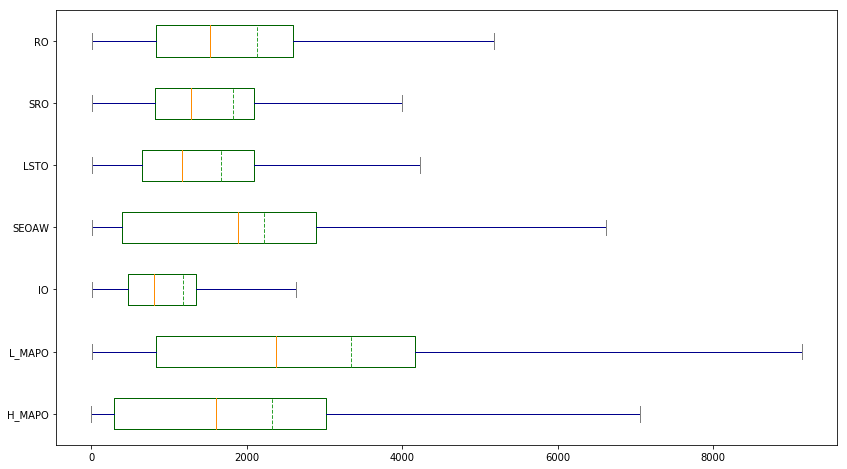

In [433]:
# plot group 1, showing distribution of men in all ages for each category

col = dict(boxes='DarkGreen', whiskers='DarkBlue', medians='DarkOrange', caps='Gray')
gr1_m_df.plot.box(color=col, sym='y+', meanline=True, showmeans=True, vert=False, showfliers=False, figsize=(14,8))
plt.show()

In [434]:
# describe men group data frame

gr1_m_df.astype(float).describe()

,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,2319.567050,3339.694444,1179.599617,2215.002874,1669.152299,1816.441571,2131.546935
std,2843.703165,3689.231048,1234.580822,2265.294376,1556.617831,1753.023041,2115.067754
min,0.000000,9.000000,3.000000,4.000000,10.000000,10.000000,10.000000
25%,283.750000,824.250000,466.000000,393.750000,649.000000,812.750000,828.750000
50%,1597.500000,2371.000000,804.500000,1881.000000,1166.000000,1275.500000,1521.000000
75%,3012.500000,4158.750000,1342.250000,2890.000000,2085.000000,2096.000000,2590.000000
max,23879.000000,33689.000000,14615.000000,23463.000000,17220.000000,23855.000000,23984.000000


### Distribution of occupations for women in all ages (based on count values)<a name="dist_w_count"></a>
[top](#top)

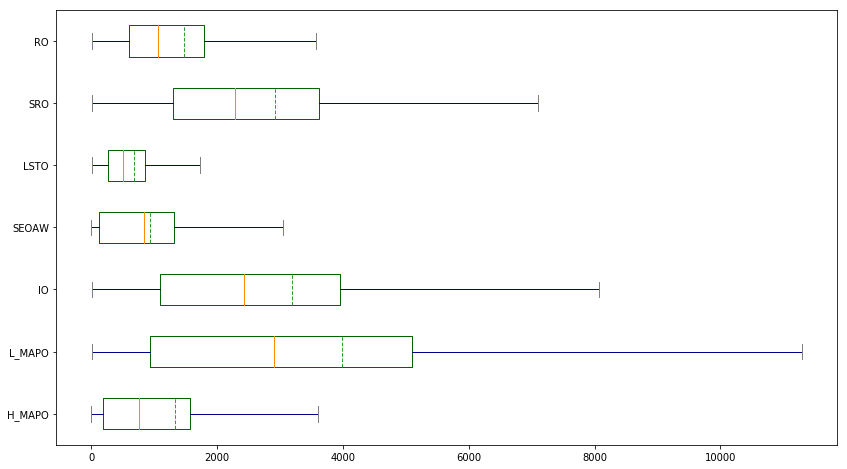

In [435]:
# plot group 2, showing distribution of women in all ages for each category

col = dict(boxes='DarkGreen', whiskers='DarkBlue', medians='DarkOrange', caps='Gray')
gr2_f_df.plot.box(color=col, sym='y+', meanline=True, showmeans=True, vert=False, showfliers=False, figsize=(14,8))
plt.show()

In [436]:
# describe women group data frame

gr2_f_df.astype(float).describe()

,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,1323.722222,3979.112069,3190.791188,936.277778,673.651341,2920.363985,1474.278736
std,1907.228697,4324.005111,3032.158634,947.784983,614.074517,2516.036666,1408.836135
min,1.000000,6.000000,5.000000,1.000000,4.000000,13.000000,7.000000
25%,177.000000,931.750000,1095.250000,116.750000,270.750000,1300.250000,590.000000
50%,758.000000,2904.000000,2433.500000,837.500000,500.500000,2275.500000,1060.000000
75%,1573.500000,5091.750000,3957.500000,1309.750000,853.250000,3626.250000,1790.500000
max,17878.000000,41976.000000,33388.000000,7630.000000,6654.000000,27689.000000,15555.000000


#### Convert values in each groups as a percentage of all groups for the particular local authority

### Men Group - all ages<a name="men_gr_pie"></a>
[top](#top)

In [437]:
per_c_l = ['H_MAPO', 'L_MAPO', 'IO', 'SEOAW', 'LSTO', 'SRO', 'RO']

#ci = qt_df.columns.get_loc('H_MAPO')
#print(qt_df.iloc[:,ci])
gr1_df_x = gr1_m_df
gr1_df_x[per_c_l] = gr1_df_x[per_c_l].apply(pd.to_numeric) # change object values to numeric
gr1_df_x['SumCol'] = gr1_df_x[per_c_l].sum(axis=1) # add sum of all values

#qt_df_x['H_MAPO_perc'] = qt_df_x['H_MAPO'] / qt_df_x['SumCol']
#qt_df_x.head()

for i in per_c_l:
    ecc = (gr1_df_x[i] / gr1_df_x['SumCol']) * 100
    gr1_df_x.drop(labels=[i], axis=1, inplace=True) # delete column i
    gr1_df_x.insert(len(gr1_m_df.columns), i, ecc) # insert copy of the column i
    gr1_df_x[i] = gr1_df_x[i].apply(lambda x: round(x, 4))
    
gr1_df_x.drop(labels=['SumCol'], axis=1, inplace=True) # delete sum column
#gr1_df_x.drop(labels=['ALLCAT'], axis=1, inplace=True) # delete ALLCAT column
#gr1_df_x.drop(labels=['NW_LTU'], axis=1, inplace=True) # delete NW_LTU column
#gr1_df_x.drop(labels=['Not classified'], axis=1, inplace=True) # delete Not classified column

gr1_df_x.head()

,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
13420,4.7098,13.6982,17.1476,4.1128,14.8922,22.0564,23.3831
13421,3.6260,11.3754,11.7359,4.9380,15.7439,26.0813,26.4994
13422,3.4269,11.4838,13.3795,5.1404,17.4991,22.2384,26.8319
13423,4.1295,11.8277,12.8983,5.2766,14.0454,25.8221,26.0005
13424,4.1178,13.5726,12.5949,5.1645,16.8622,23.5335,24.1546


Plot distribution of occupation types of men in all age groups as a percentage

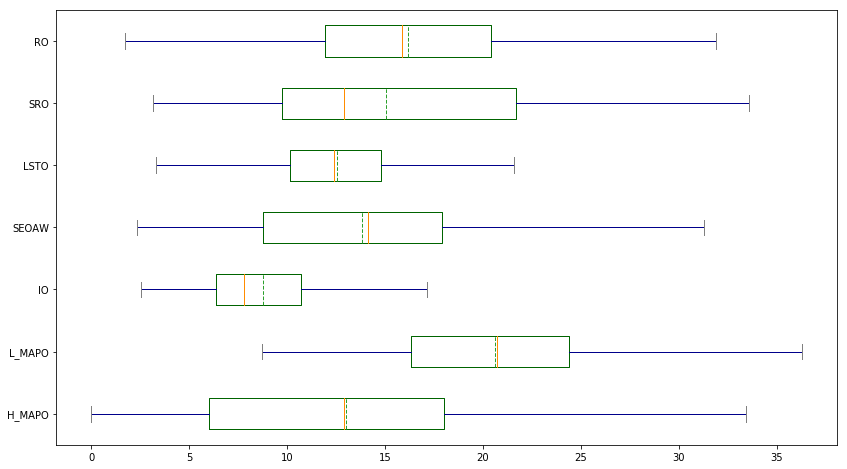

In [438]:
# plot group 1, showing distribution of men in all ages for each category

col = dict(boxes='DarkGreen', whiskers='DarkBlue', medians='DarkOrange', caps='Gray')
gr1_df_x.plot.box(color=col, sym='y+', meanline=True, showmeans=True, vert=False, showfliers=False, figsize=(14,8))
plt.show()

In [439]:
# describe men group data frame

gr1_df_x.astype(float).describe()

,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,13.017893,20.629650,8.765530,13.827571,12.527040,15.046733,16.185584
std,7.403887,5.439771,3.465401,5.697796,3.272301,6.611670,5.675250
min,0.000000,8.705400,2.510500,2.325600,3.156300,3.156300,1.703400
25%,6.010625,16.319725,6.351125,8.767025,10.141225,9.740950,11.913175
50%,12.911900,20.697900,7.815000,14.126350,12.407200,12.912000,15.878950
75%,18.018175,24.394450,10.718850,17.879300,14.790525,21.689575,20.386775
max,44.639300,43.023300,53.736100,41.004200,26.562500,33.571800,35.724500


Pie Chart showing percentage across all occupation types for men in all ages

In [440]:
# create a new Data Frame containing occupation types and percentage per each group

per_c_l = ['H_MAPO', 'L_MAPO', 'IO', 'SEOAW', 'LSTO', 'SRO', 'RO']

avg_l = []
for i in per_c_l:
    avg_l.append(gr1_df_x[i].mean())
d = {'MenGroup':per_c_l, 'Percenage':avg_l}
pdf_m = pd.DataFrame(data=d, dtype=np.float)

pdf_m.head(7)

,MenGroup,Percenage
0,H_MAPO,13.017893
1,L_MAPO,20.629650
2,IO,8.765530
3,SEOAW,13.827571
4,LSTO,12.527040
5,SRO,15.046733
6,RO,16.185584


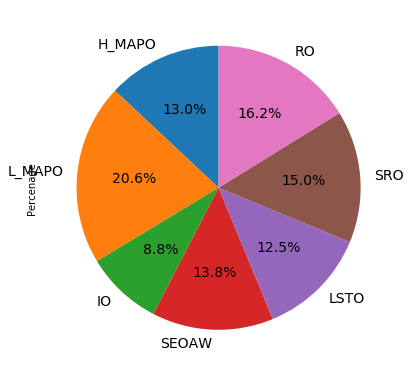

In [441]:
# plot chart from the data frame pdf_m

plt.figure(figsize=(14,8))
ax1 = plt.subplot(121, aspect='equal')
pdf_m.plot(kind='pie', y='Percenage', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, labels=pdf_m['MenGroup'], legend = False, fontsize=14)

plt.show()

### Women group - all ages<a name="women_gr_pie"></a>
[top](#top)

In [442]:
per_c_l = ['H_MAPO', 'L_MAPO', 'IO', 'SEOAW', 'LSTO', 'SRO', 'RO']


#ci = qt_df.columns.get_loc('H_MAPO')
#print(qt_df.iloc[:,ci])
gr2_df_x = gr2_f_df
gr2_df_x[per_c_l] = gr2_df_x[per_c_l].apply(pd.to_numeric) # change object values to numeric
gr2_df_x['SumCol'] = gr2_df_x[per_c_l].sum(axis=1) # add sum of all values

#qt_df_x['H_MAPO_perc'] = qt_df_x['H_MAPO'] / qt_df_x['SumCol']
#qt_df_x.head()

for i in per_c_l:
    ecc = (gr2_df_x[i] / gr2_df_x['SumCol']) * 100
    gr2_df_x.drop(labels=[i], axis=1, inplace=True) # delete column i
    gr2_df_x.insert(len(gr2_f_df.columns), i, ecc) # insert copy of the column i
    gr2_df_x[i] = gr2_df_x[i].apply(lambda x: round(x, 4))
    
gr2_df_x.drop(labels=['SumCol'], axis=1, inplace=True) # delete sum column
#gr2_df_x.drop(labels=['ALLCAT'], axis=1, inplace=True) # delete ALLCAT column
#gr2_df_x.drop(labels=['NW_LTU'], axis=1, inplace=True) # delete NW_LTU column
#gr2_df_x.drop(labels=['Not classified'], axis=1, inplace=True) # delete Not classified column

gr2_df_x.head()

,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
24640,2.3533,14.7498,26.9804,1.2595,6.0656,32.9798,15.6115
24641,2.4157,14.2039,24.5961,1.4980,5.3333,35.6549,16.2980
24642,1.8555,14.2519,24.2006,1.8555,4.6980,36.2416,16.8970
24643,2.3517,14.8756,21.7391,1.3946,4.2658,39.7320,15.6412
24644,2.4838,14.6701,21.9146,1.9922,7.0116,34.0880,17.8396


#### Plot distribution of occupation types of women in all age groups as a percentage

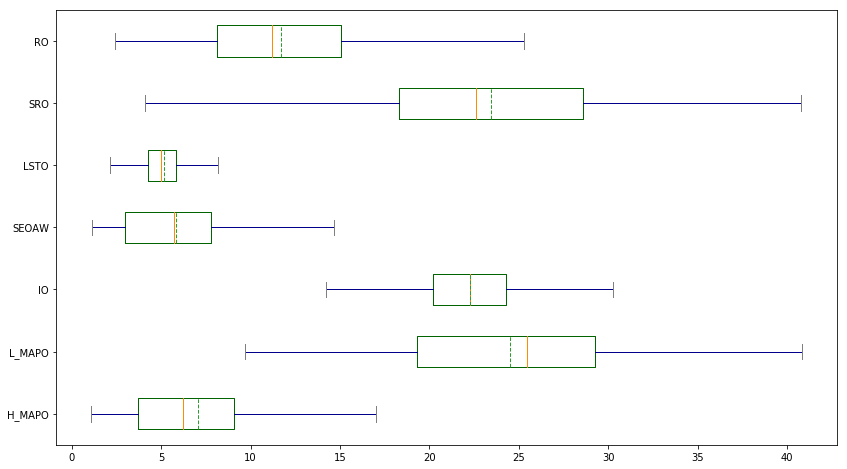

In [443]:
# plot group 1, showing distribution of men in all ages for each category

col = dict(boxes='DarkGreen', whiskers='DarkBlue', medians='DarkOrange', caps='Gray')
gr2_df_x.plot.box(color=col, sym='y+', meanline=True, showmeans=True, vert=False, showfliers=False, figsize=(14,8))
plt.show()

In [444]:
# describe statistical values across all occupation groups

gr2_df_x.astype(float).describe()

,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,7.079491,24.491815,22.270363,5.826099,5.139603,23.467365,11.725264
std,4.486039,6.151412,3.320572,3.132010,1.321875,7.060984,4.370241
min,1.098900,9.677400,8.064500,1.146700,1.557100,4.093600,2.412300
25%,3.676400,19.289550,20.175325,2.963625,4.269900,18.296175,8.145275
50%,6.245500,25.440200,22.261300,5.728350,4.980250,22.629050,11.189800
75%,9.067500,29.260475,24.273225,7.780450,5.833125,28.571400,15.047725
max,40.058500,40.821100,35.698200,31.111100,17.741900,40.800200,33.871000


#### Pie Chart showing percentage across all occupation types for women in all ages

In [445]:
# create a new Data Frame containing occupation types and percentage per each group

per_c_l = ['H_MAPO', 'L_MAPO', 'IO', 'SEOAW', 'LSTO', 'SRO', 'RO']

avg_l = []
for i in per_c_l:
    avg_l.append(gr2_df_x[i].mean())
d = {'Group':per_c_l, 'Percenage':avg_l}
pdf_w = pd.DataFrame(data=d, dtype=np.float)

pdf_w.head(7)

,Group,Percenage
0,H_MAPO,7.079491
1,L_MAPO,24.491815
2,IO,22.270363
3,SEOAW,5.826099
4,LSTO,5.139603
5,SRO,23.467365
6,RO,11.725264


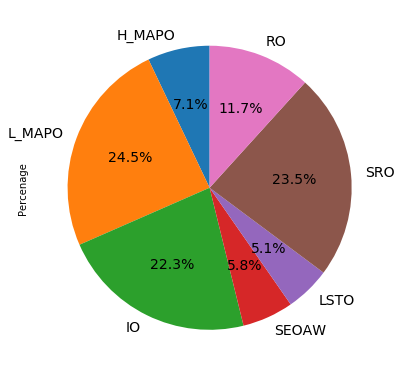

In [446]:
# plot chart
plt.figure(figsize=(14,8))
ax1 = plt.subplot(121, aspect='equal')
pdf_w.plot(kind='pie', y='Percenage', ax=ax1, autopct='%1.1f%%', startangle=90, shadow=False, labels=pdf_w['Group'], legend = False, fontsize=14)

plt.show()

#### Distribution of women in all ages for each category

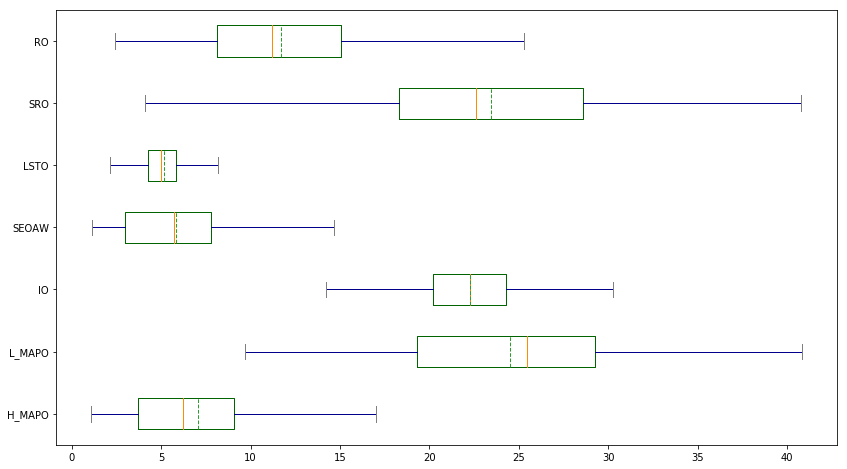

In [447]:
# plot group 2, showing distribution of women in all ages for each category

col = dict(boxes='DarkGreen', whiskers='DarkBlue', medians='DarkOrange', caps='Gray')
gr2_df_x.plot.box(color=col, sym='y+', meanline=True, showmeans=True, vert=False, showfliers=False, figsize=(14,8))
plt.show()

In [448]:
gr2_df_x.astype(int).describe()

,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,6.576628,23.996169,21.775862,5.335249,4.630268,22.956897,11.236590
std,4.499374,6.155385,3.339463,3.144440,1.355109,7.053763,4.374221
min,1.000000,9.000000,8.000000,1.000000,1.000000,4.000000,2.000000
25%,3.000000,19.000000,20.000000,2.000000,4.000000,18.000000,8.000000
50%,6.000000,25.000000,22.000000,5.000000,4.000000,22.000000,11.000000
75%,9.000000,29.000000,24.000000,7.000000,5.000000,28.000000,15.000000
max,40.000000,40.000000,35.000000,31.000000,17.000000,40.000000,33.000000


### Statistic data for each age group for both men and women<a name="stats_m_w"></a>
[top](#top)

In [449]:
# men 16-24
gr1_m_l = ['M16-24All', 'M25-49All', 'M50-64All']
gr2_f_l = ['F16-24All', 'F25-49All', 'F50-64All']

m1624_stat_df = filterGroups(m_df, ['M16-24All'], 'SAE')
m1624_stat_df = m1624_stat_df[bpc]
m1624_stat_df.astype(int).describe()

348  rows filtered out of  31320


,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,241.215517,700.324713,569.410920,323.353448,663.017241,1042.844828,910.836207
std,222.636668,513.820976,445.814199,211.970592,410.164731,705.775363,646.394295
min,0.000000,9.000000,3.000000,4.000000,10.000000,10.000000,10.000000
25%,113.000000,392.750000,292.000000,189.750000,419.750000,613.000000,533.250000
50%,170.000000,516.500000,446.000000,250.000000,549.000000,843.500000,714.000000
75%,285.250000,882.000000,751.000000,398.750000,771.000000,1250.500000,1047.750000
max,1633.000000,4314.000000,3742.000000,1597.000000,3133.000000,6611.000000,5546.000000


In [450]:
# women 16-24

w1624_stat_df = filterGroups(m_df, ['F16-24All'], 'SAE')
w1624_stat_df = w1624_stat_df[bpc]
w1624_stat_df.astype(int).describe()

348  rows filtered out of  31320


,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,154.189655,763.566092,994.399425,105.945402,252.083333,1298.166667,630.738506
std,162.254661,584.219590,750.381873,89.585307,157.425675,890.214976,415.795752
min,1.000000,6.000000,5.000000,1.000000,4.000000,13.000000,7.000000
25%,65.000000,410.750000,538.750000,58.000000,151.000000,757.750000,384.750000
50%,98.500000,563.000000,733.500000,77.000000,211.000000,1053.500000,516.000000
75%,186.000000,958.500000,1295.250000,117.750000,303.000000,1597.750000,757.000000
max,1175.000000,5149.000000,6742.000000,603.000000,1328.000000,8129.000000,3461.000000


In [451]:
# men 25-49

m2549_stat_df = filterGroups(m_df, ['M25-49All'], 'SAE')
m2549_stat_df = m2549_stat_df[bpc]
m2549_stat_df.astype(int).describe()

348  rows filtered out of  31320


,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,348.00000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,4461.37931,6376.718391,2077.623563,3793.890805,2836.643678,2844.045977,3320.885057
std,3671.79305,4637.794884,1664.091463,2639.104390,1909.524199,2359.745856,2688.865232
min,23.00000,78.000000,20.000000,98.000000,63.000000,36.000000,34.000000
25%,2032.00000,3524.750000,1029.500000,2258.250000,1687.750000,1457.750000,1721.000000
50%,3180.50000,4754.500000,1478.500000,2851.000000,2191.500000,2090.000000,2550.000000
75%,5556.75000,7987.250000,2755.500000,4596.500000,3432.500000,3506.000000,3919.750000
max,23879.00000,33689.000000,14615.000000,23463.000000,17220.000000,23855.000000,23984.000000


In [452]:
# women 25-49

w2549_stat_df = filterGroups(m_df, ['F25-49All'], 'SAE')
w2549_stat_df = w2549_stat_df[bpc]
w2549_stat_df.astype(int).describe()

348  rows filtered out of  31320


,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2859.025862,7584.031609,5444.531609,1615.747126,1140.945402,4431.908046,2176.922414
std,2580.374399,5285.825459,3690.564111,1032.721194,738.901069,3081.636927,1695.652409
min,17.000000,88.000000,74.000000,63.000000,29.000000,53.000000,28.000000
25%,1233.500000,4334.250000,3152.500000,976.250000,684.750000,2551.250000,1175.750000
50%,1997.500000,5678.000000,4163.500000,1346.500000,916.000000,3501.000000,1665.500000
75%,3436.250000,9426.000000,7078.250000,1826.250000,1395.500000,5495.500000,2507.500000
max,17878.000000,41976.000000,33388.000000,7499.000000,6654.000000,27689.000000,15555.000000


In [453]:
# men 50-64

m5064_stat_df = filterGroups(m_df, ['M50-64All'], 'SAE')
m5064_stat_df = m5064_stat_df[bpc]
m5064_stat_df.astype(int).describe()

348  rows filtered out of  31320


,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2256.106322,2942.040230,891.764368,2527.764368,1507.795977,1562.433908,2162.919540
std,1355.842419,1655.760246,590.035149,1492.523499,1029.720863,1202.732702,1698.375465
min,24.000000,51.000000,6.000000,90.000000,16.000000,21.000000,23.000000
25%,1387.750000,1932.750000,528.000000,1664.500000,888.500000,838.250000,1163.500000
50%,1974.000000,2524.500000,724.000000,2166.000000,1174.500000,1193.500000,1658.000000
75%,2804.000000,3482.750000,1079.000000,2945.750000,1773.750000,1872.500000,2531.750000
max,9563.000000,12042.000000,4800.000000,14233.000000,8173.000000,11836.000000,13391.000000


In [454]:
# women 50-64

w5064_stat_df = filterGroups(m_df, ['F50-64All'], 'SAE')
w5064_stat_df = w5064_stat_df[bpc]
w5064_stat_df.astype(int).describe()

348  rows filtered out of  31320


,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,957.951149,3589.738506,3133.442529,1087.140805,627.925287,3031.017241,1615.175287
std,615.628411,2088.799466,1875.177726,669.518452,404.174029,1948.358887,1299.662934
min,6.000000,62.000000,32.000000,47.000000,7.000000,32.000000,15.000000
25%,556.750000,2371.000000,2007.000000,702.500000,386.750000,1841.500000,858.750000
50%,795.500000,3145.500000,2622.500000,975.000000,527.500000,2427.500000,1233.000000
75%,1197.000000,4209.000000,3617.000000,1286.500000,730.000000,3649.000000,1868.500000
max,4241.000000,15782.000000,14751.000000,7630.000000,3283.000000,15052.000000,9968.000000


### Differences between number of men and women working at the specific occupation type in each age group<a name="age_cat_diff"></a>

[top](#top)

Select three groups: 
1. Men and Females at age 16-24 from all ethnic groups
2. Men and Females at age 25-49 from all ethnic groups
3. Men and Females at age 50-64 from all ethnic groups

Then create three data frames; each of which contains two clasters: 
men and women in the specific age range (16-24, 25-49, 50-64)

In [455]:
# create three groups

gr1_1624_l = ['M16-24All','F16-24All']
gr2_2549_l = ['M25-49All','F25-49All']
gr3_5064_l = ['M50-64All','F50-64All']

In [456]:
# filter the current sk2 data frame by 'M16-24All','F16-24All'

gr1_1624_df = filterGroups(m_df, gr1_1624_l, 'SAE')
gr1_1624_df.head()

696  rows filtered out of  31320


,LA,LAC,ALLCAT,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO,NW_LTU,Not classified,Sex,Age,Ethnic_Group,SAE
13420,Darlington,E06000005,5604,142,413,517,124,449,665,705,599,1990,M,16-24,All,M16-24All
13421,County Durham,E06000047,31554,503,1578,1628,685,2184,3618,3676,3167,14515,M,16-24,All,M16-24All
13422,Hartlepool,E06000001,5512,94,315,367,141,480,610,736,720,2049,M,16-24,All,M16-24All
13423,Middlesbrough,E06000002,10312,162,464,506,207,551,1013,1020,1263,5126,M,16-24,All,M16-24All
13424,Northumberland,E06000057,15711,358,1180,1095,449,1466,2046,2100,1435,5582,M,16-24,All,M16-24All


In [457]:
# filter the current sk2 data frame by 'M25-49All','F25-49All'

gr2_2549_df = filterGroups(m_df, gr2_2549_l, 'SAE')
gr2_2549_df.head()

696  rows filtered out of  31320


,LA,LAC,ALLCAT,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO,NW_LTU,Not classified,Sex,Age,Ethnic_Group,SAE
15664,Darlington,E06000005,17428,2276,3780,1671,1818,1935,2107,2655,1009,177,M,25-49,All,M25-49All
15665,County Durham,E06000047,82527,9216,15359,6474,9086,10387,11127,14411,4845,1622,M,25-49,All,M25-49All
15666,Hartlepool,E06000001,14406,1304,2605,1102,1507,1975,1762,2565,1430,156,M,25-49,All,M25-49All
15667,Middlesbrough,E06000002,22032,1741,3529,1687,2309,2582,3109,3652,2447,976,M,25-49,All,M25-49All
15668,Northumberland,E06000057,47422,6130,9964,3956,6372,5637,5613,6635,2695,420,M,25-49,All,M25-49All


In [458]:
# filter the current sk2 data frame by 'M50-64All','F50-64All'

gr3_5064_df = filterGroups(m_df, gr3_5064_l, 'SAE')
gr3_5064_df.head()

696  rows filtered out of  31320


,LA,LAC,ALLCAT,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO,NW_LTU,Not classified,Sex,Age,Ethnic_Group,SAE
17908,Darlington,E06000005,10001,1335,2007,668,1438,1061,1197,1910,363,22,M,50-64,All,M50-64All
17909,County Durham,E06000047,50952,5788,9266,3199,6717,6523,6406,11174,1763,116,M,50-64,All,M50-64All
17910,Hartlepool,E06000001,8869,786,1406,466,1027,1305,1221,2105,523,30,M,50-64,All,M50-64All
17911,Middlesbrough,E06000002,12140,1050,1926,757,1193,1722,1747,2921,783,41,M,50-64,All,M50-64All
17912,Northumberland,E06000057,34442,5170,7129,2339,5804,4058,3662,5234,953,93,M,50-64,All,M50-64All


In [459]:
# save gr3_5064_df as csv and check in Excel

# uncomment to save
#saveDataFrame('gr3_5064_df', gr3_5064_df)

In [460]:
# Change all data types to Integers (currently stored as Objects)

dtstr = ''
for i in bpc:
    dtstr = dtstr + str(gr1_1624_df[i].dtype) + ', '
print(dtstr)
    

gr1_1624_df = gr1_1624_df[bpc]
gr1_1624_df = gr1_1624_df.astype(int)

gr2_2549_df = gr2_2549_df[bpc]
gr2_2549_df = gr2_2549_df.astype(int)

gr3_5064_df = gr3_5064_df[bpc]
gr3_5064_df = gr3_5064_df.astype(int)

dtint = ''
for i in bpc:
    dtint = dtint + str(gr1_1624_df[i].dtype) + ', '
print(dtint)

object, object, object, object, object, object, object, 
int32, int32, int32, int32, int32, int32, int32, 


In [461]:
hl = ['H_MAPO', 'L_MAPO', 'IO', 'SEOAW', 'LSTO', 'SRO', 'RO']

sfe = filterGroups(m_df, ['M16-24All'], 'SAE')
sfe = sfe[hl].astype(int)

sfe.head()

348  rows filtered out of  31320


,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
13420,142,413,517,124,449,665,705
13421,503,1578,1628,685,2184,3618,3676
13422,94,315,367,141,480,610,736
13423,162,464,506,207,551,1013,1020
13424,358,1180,1095,449,1466,2046,2100


348  rows filtered out of  31320
348  rows filtered out of  31320


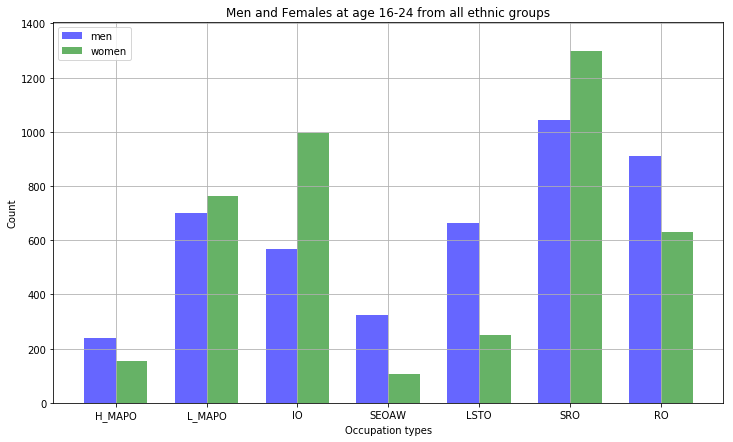

In [462]:
# plot men and women at age 16-24

gr1_1624_m_df = filterGroups(m_df, ['M16-24All'], 'SAE')
gr1_1624_f_df = filterGroups(m_df, ['F16-24All'], 'SAE')

ml = []
fl = []
hl = ['H_MAPO', 'L_MAPO', 'IO', 'SEOAW', 'LSTO', 'SRO', 'RO']


# create a list with an average values for reading, writing and maths scores
for i in hl:
    ml.append(gr1_1624_m_df[i].astype(int).mean())
    fl.append(gr1_1624_f_df[i].astype(int).mean())
    
ml = [round(x, 2) for x in ml]
fl = [round(x, 2) for x in fl]

# create a figure for plotting
fig, ax = plt.subplots(figsize=(12,7))
index = np.arange(7)
bw = 0.35
op = 0.6

# create bar graphs for male and female
m_bar = plt.bar(index, ml, bw, alpha=op, label='men', color='b', align='center')
f_bar = plt.bar(index + bw, fl, bw, alpha=op, label='women', color='g', align='center')

# set ax
ax.set_xlabel('Occupation types')
ax.set_ylabel('Count')
ax.set_title('Men and Females at age 16-24 from all ethnic groups')
ax.set_xticks(index + bw /2)
ax.set_xticklabels(('H_MAPO', 'L_MAPO', 'IO', 'SEOAW', 'LSTO', 'SRO', 'RO'))
ax.legend(loc='upper left')

plt.ylim([0, max(ml + fl) + min(ml + fl)])

plt.grid()
plt.show()

In [463]:
# statistical description of the graph above for men in age group 16-24

gr1_1624_m_df[hl].astype(int).describe()

,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,241.215517,700.324713,569.410920,323.353448,663.017241,1042.844828,910.836207
std,222.636668,513.820976,445.814199,211.970592,410.164731,705.775363,646.394295
min,0.000000,9.000000,3.000000,4.000000,10.000000,10.000000,10.000000
25%,113.000000,392.750000,292.000000,189.750000,419.750000,613.000000,533.250000
50%,170.000000,516.500000,446.000000,250.000000,549.000000,843.500000,714.000000
75%,285.250000,882.000000,751.000000,398.750000,771.000000,1250.500000,1047.750000
max,1633.000000,4314.000000,3742.000000,1597.000000,3133.000000,6611.000000,5546.000000


In [464]:
# statistical description of the graph above for women in age group 16-24

gr1_1624_f_df[hl].astype(int).describe()

,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,154.189655,763.566092,994.399425,105.945402,252.083333,1298.166667,630.738506
std,162.254661,584.219590,750.381873,89.585307,157.425675,890.214976,415.795752
min,1.000000,6.000000,5.000000,1.000000,4.000000,13.000000,7.000000
25%,65.000000,410.750000,538.750000,58.000000,151.000000,757.750000,384.750000
50%,98.500000,563.000000,733.500000,77.000000,211.000000,1053.500000,516.000000
75%,186.000000,958.500000,1295.250000,117.750000,303.000000,1597.750000,757.000000
max,1175.000000,5149.000000,6742.000000,603.000000,1328.000000,8129.000000,3461.000000


348  rows filtered out of  31320
348  rows filtered out of  31320


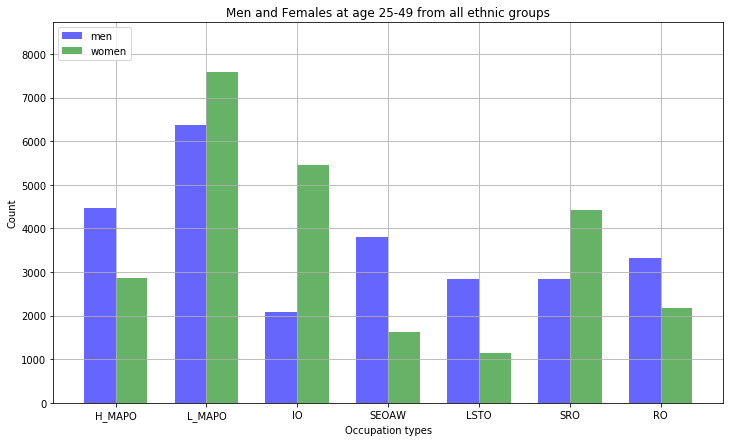

In [465]:
# plot men and women at age 25-49

gr2_2549_m_df = filterGroups(m_df, ['M25-49All'], 'SAE')
gr2_2549_f_df = filterGroups(m_df, ['F25-49All'], 'SAE')

ml = []
fl = []
hl = ['H_MAPO', 'L_MAPO', 'IO', 'SEOAW', 'LSTO', 'SRO', 'RO']


# create a list with an average values for reading, writing and maths scores
for i in hl:
    ml.append(gr2_2549_m_df[i].astype(int).mean())
    fl.append(gr2_2549_f_df[i].astype(int).mean())
    
ml = [round(x, 2) for x in ml]
fl = [round(x, 2) for x in fl]

# create a figure for plotting
fig, ax = plt.subplots(figsize=(12,7))
index = np.arange(7)
bw = 0.35
op = 0.6

# create bar graphs for male and female
m_bar = plt.bar(index, ml, bw, alpha=op, label='men', color='b', align='center')
f_bar = plt.bar(index + bw, fl, bw, alpha=op, label='women', color='g', align='center')

# set ax
ax.set_xlabel('Occupation types')
ax.set_ylabel('Count')
ax.set_title('Men and Females at age 25-49 from all ethnic groups')
ax.set_xticks(index + bw /2)
ax.set_xticklabels(('H_MAPO', 'L_MAPO', 'IO', 'SEOAW', 'LSTO', 'SRO', 'RO'))
ax.legend(loc='upper left')

plt.ylim([0, max(ml + fl) + min(ml + fl)])

plt.grid()
plt.show()

In [466]:
# statistical description of the graph above for men in age group 25-49

gr2_2549_m_df[hl].astype(int).describe()

,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,348.00000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,4461.37931,6376.718391,2077.623563,3793.890805,2836.643678,2844.045977,3320.885057
std,3671.79305,4637.794884,1664.091463,2639.104390,1909.524199,2359.745856,2688.865232
min,23.00000,78.000000,20.000000,98.000000,63.000000,36.000000,34.000000
25%,2032.00000,3524.750000,1029.500000,2258.250000,1687.750000,1457.750000,1721.000000
50%,3180.50000,4754.500000,1478.500000,2851.000000,2191.500000,2090.000000,2550.000000
75%,5556.75000,7987.250000,2755.500000,4596.500000,3432.500000,3506.000000,3919.750000
max,23879.00000,33689.000000,14615.000000,23463.000000,17220.000000,23855.000000,23984.000000


In [467]:
# statistical description of the graph above for women in age group 25-49

gr2_2549_f_df[hl].astype(int).describe()

,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2859.025862,7584.031609,5444.531609,1615.747126,1140.945402,4431.908046,2176.922414
std,2580.374399,5285.825459,3690.564111,1032.721194,738.901069,3081.636927,1695.652409
min,17.000000,88.000000,74.000000,63.000000,29.000000,53.000000,28.000000
25%,1233.500000,4334.250000,3152.500000,976.250000,684.750000,2551.250000,1175.750000
50%,1997.500000,5678.000000,4163.500000,1346.500000,916.000000,3501.000000,1665.500000
75%,3436.250000,9426.000000,7078.250000,1826.250000,1395.500000,5495.500000,2507.500000
max,17878.000000,41976.000000,33388.000000,7499.000000,6654.000000,27689.000000,15555.000000


348  rows filtered out of  31320
348  rows filtered out of  31320


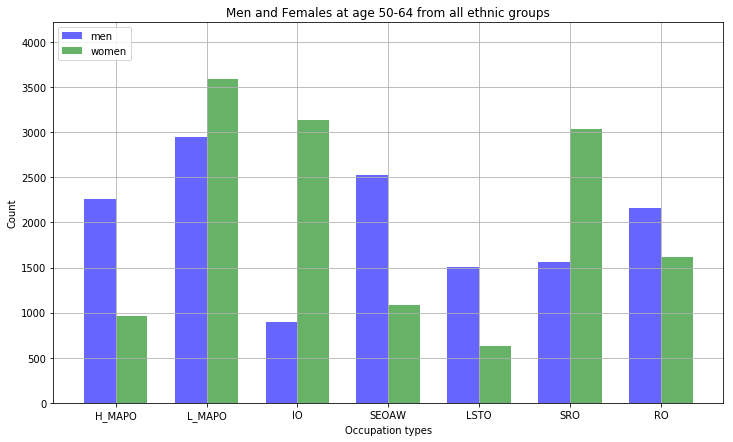

In [468]:
# plot men and women at age 50-64

gr3_5064_m_df = filterGroups(m_df, ['M50-64All'], 'SAE')
gr3_5064_f_df = filterGroups(m_df, ['F50-64All'], 'SAE')

ml = []
fl = []
hl = ['H_MAPO', 'L_MAPO', 'IO', 'SEOAW', 'LSTO', 'SRO', 'RO']


# create a list with an average values for reading, writing and maths scores
for i in hl:
    ml.append(gr3_5064_m_df[i].astype(int).mean())
    fl.append(gr3_5064_f_df[i].astype(int).mean())
    
ml = [round(x, 2) for x in ml]
fl = [round(x, 2) for x in fl]

# create a figure for plotting
fig, ax = plt.subplots(figsize=(12,7))
index = np.arange(7)
bw = 0.35
op = 0.6

# create bar graphs for male and female
m_bar = plt.bar(index, ml, bw, alpha=op, label='men', color='b', align='center')
f_bar = plt.bar(index + bw, fl, bw, alpha=op, label='women', color='g', align='center')

# set ax
ax.set_xlabel('Occupation types')
ax.set_ylabel('Count')
ax.set_title('Men and Females at age 50-64 from all ethnic groups')
ax.set_xticks(index + bw /2)
ax.set_xticklabels(('H_MAPO', 'L_MAPO', 'IO', 'SEOAW', 'LSTO', 'SRO', 'RO'))
ax.legend(loc='upper left')

plt.ylim([0, max(ml + fl) + min(ml + fl)])

plt.grid()
plt.show()

In [469]:
# statistical description of the graph above for men in age group 50-64

gr3_5064_m_df[hl].astype(int).describe()

,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2256.106322,2942.040230,891.764368,2527.764368,1507.795977,1562.433908,2162.919540
std,1355.842419,1655.760246,590.035149,1492.523499,1029.720863,1202.732702,1698.375465
min,24.000000,51.000000,6.000000,90.000000,16.000000,21.000000,23.000000
25%,1387.750000,1932.750000,528.000000,1664.500000,888.500000,838.250000,1163.500000
50%,1974.000000,2524.500000,724.000000,2166.000000,1174.500000,1193.500000,1658.000000
75%,2804.000000,3482.750000,1079.000000,2945.750000,1773.750000,1872.500000,2531.750000
max,9563.000000,12042.000000,4800.000000,14233.000000,8173.000000,11836.000000,13391.000000


In [470]:
# statistical description of the graph above for women in age group 50-49

gr3_5064_f_df[hl].astype(int).describe()

,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,957.951149,3589.738506,3133.442529,1087.140805,627.925287,3031.017241,1615.175287
std,615.628411,2088.799466,1875.177726,669.518452,404.174029,1948.358887,1299.662934
min,6.000000,62.000000,32.000000,47.000000,7.000000,32.000000,15.000000
25%,556.750000,2371.000000,2007.000000,702.500000,386.750000,1841.500000,858.750000
50%,795.500000,3145.500000,2622.500000,975.000000,527.500000,2427.500000,1233.000000
75%,1197.000000,4209.000000,3617.000000,1286.500000,730.000000,3649.000000,1868.500000
max,4241.000000,15782.000000,14751.000000,7630.000000,3283.000000,15052.000000,9968.000000


In [471]:
# show variance for LSTO for each age group

lsto_d = {'age': ['16-24', '25-49', '50-34'], 'male': [663, 2836, 1507], 'female': [252, 1140, 627], 'variance': [1.63, 1.48, 1.40]}
lsto_df = pd.DataFrame(data=lsto_d)
lsto_df

,age,female,male,variance
0,16-24,252,663,1.63
1,25-49,1140,2836,1.48
2,50-34,627,1507,1.40


## Cleaning data for Question 2<a name="cleanup_q2"></a>
[top](#top)

### Post Codes files cleanup<a name="post_code_cleanup"></a>
[top](#top)

Get all Postcodes from all postcodes files and create a data frame

In [472]:
#p1_df = pd.read_csv('data/Performancetables/Postcodes/pcall_refined/pc1.csv', low_memory=False)
#p2_df = pd.read_csv('data/Performancetables/Postcodes/pcall_refined/pc2.csv', low_memory=False)
#p3_df = pd.read_csv('data/Performancetables/Postcodes/pcall_refined/pc3.csv', low_memory=False)
#p4_df = pd.read_csv('data/Performancetables/Postcodes/pcall_refined/pc4.csv', low_memory=False)
#p5_df = pd.read_csv('data/Performancetables/Postcodes/pcall_refined/pc5.csv', low_memory=False)
#p6_df = pd.read_csv('data/Performancetables/Postcodes/pcall_refined/pc6.csv', low_memory=False)

#p1_df.head()
#pca_df = pd.merge(p1_df, p2_df)
#pca_df = p1_df.join(p2_df, on='Column 1')
#pca_df = pd.concat(p1_df, p2_df)
#pca_df = pd.merge(p1_df, p2_df, p3_df, p4_df, p5_df, p6_df)
#pca_df.head()

In [473]:
# concatenate all post code files and check whether there are any missing or extra rows in the output data frame

#pca_df = pd.concat([p1_df, p2_df, p3_df, p4_df, p5_df, p6_df])
#chk_sum = len(p1_df)+len(p2_df)+len(p3_df)+len(p4_df)+len(p5_df)+len(p6_df)
#chk_sum_pca = len(pca_df)
#print(chk_sum == chk_sum_pca)

In [474]:
# Only Column 9 holds an authority that can be linked to 1279924960.csv

#pca_df.drop(['Column 2','Column 3','Column 4','Column 5','Column 6','Column 7','Column 8','Column 10'], axis=1, inplace=True)
#pca_df.head()

Function to convert all post code to the correct format. The algorithm updates all postcodes to remove any possible white spaces. However, if the source post code contains any extra characters, the output post code will be invalid consequently. The algorithm below follows Post code structure from the mrs.org
https://www.mrs.org.uk/pdf/postcodeformat.pdf

In [475]:
# re-format all post codes in ColformatPostCodeumn 1 to the correct format

#pca_df['Column 1'] = pca_df['Column 1'].apply(lambda x: formatPostCode(x))
#pca_df.head()

In [476]:
# re-name column names

#pca_df.rename(columns = {'Column 1': 'PCODE', 'Column 9': 'AU'}, inplace=True)
#pca_df.head()

### KS2 dataset cleanup<a name="ks2_cleanup"></a>
[top](#top)

In [477]:
df = pd.read_csv('data/Performancetables/england_ks2final.csv', low_memory=False)
df.head()

,RECTYPE,ALPHAIND,LEA,ESTAB,URN,SCHNAME,ADDRESS1,ADDRESS2,ADDRESS3,TOWN,...,TSENELE,PSENELE,TSENELK,PSENELK,TSENELST,PSENELST,TSENELSAP,PSENELSAP,SENELN,PSENELN
0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1%,NaN,14%,NaN,2%,NaN,0%,NaN,0%
1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1%,NaN,15%,NaN,2%,NaN,0%,NaN,0%
2,1,53372.0,201.0,3614.0,100000.0,Sir John Cass's Foundation Primary School,St James's Passage,Duke's Place,NaN,London,...,0,0%,5,18%,0,0%,0,0%,0,0%
3,3,NaN,201.0,NaN,NaN,City of London,NaN,NaN,NaN,NaN,...,NaN,0%,NaN,18%,NaN,0%,NaN,0%,NaN,0%
4,1,11156.0,202.0,3323.0,100028.0,"Christ Church Primary School, Hampstead",Christ Church Hill,NaN,NaN,London,...,0,0%,2,10%,0,0%,0,0%,0,0%


In [478]:
# create a new dataset that includes only those columns that might be used for analysis
cs1 = ['URN', 'SCHNAME', 'PCODE', 'NFTYPE', 'AGERANGE', 'TOTPUPS', 'TPUPYEAR', 'BELIG', 'GELIG', 'PBELIG', 'PGELIG', 'READPROG', 'READPROG_LOWER', 'READPROG_UPPER', 'WRITPROG', 'WRITPROG_LOWER', 'WRITPROG_UPPER', 'MATPROG', 'PTREAD_EXP', 'PTGPS_EXP', 'PTMAT_EXP', 'PTWRITTA_EXP', 'READPROG_B', 'READPROG_B_LOWER', 'READPROG_B_UPPER', 'READPROG_G', 'READPROG_G_LOWER', 'READPROG_G_UPPER', 'READPROG_NotFSM6CLA1A_LOWER', 'READPROG_NotFSM6CLA1A_UPPER', 'WRITPROG_B', 'WRITPROG_G', 'MATPROG_B', 'MATPROG_G', 'TEALGRP1', 'PTEALGRP1'
]
cs2 = ['READPROG_L', 'READPROG_L_LOWER', 'READPROG_L_UPPER', 'READPROG_M', 'READPROG_M_LOWER', 'READPROG_M_UPPER', 'READPROG_H', 'READPROG_H_LOWER', 'READPROG_H_UPPER', 'READPROG_FSM6CLA1A', 'READPROG_FSM6CLA1A_LOWER', 'READPROG_FSM6CLA1A_UPPER', 'READPROG_NotFSM6CLA1A', 'DIFFN_READPROG', 'READPROG_EAL', 'READPROG_EAL_LOWER', 'READPROG_EAL_UPPER', 'READPROG_MOBN', 'READPROG_MOBN_LOWER', 'READPROG_MOBN_UPPER']

cs3 = cs1 + cs2
p_df = df[cs3]
p_df.head()

,URN,SCHNAME,PCODE,NFTYPE,AGERANGE,TOTPUPS,TPUPYEAR,BELIG,GELIG,PBELIG,...,READPROG_FSM6CLA1A_LOWER,READPROG_FSM6CLA1A_UPPER,READPROG_NotFSM6CLA1A,DIFFN_READPROG,READPROG_EAL,READPROG_EAL_LOWER,READPROG_EAL_UPPER,READPROG_MOBN,READPROG_MOBN_LOWER,READPROG_MOBN_UPPER
0,NaN,NaN,NaN,NaN,NaN,4491850,592719.0,302432,289836,51%,...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,NaN,NaN,NaN,4406360,585953.0,299318,286854,51%,...,0,0,0.3,0,0.3,0,0,0,0,0
2,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,VA,3-11,250,28.0,16,12,57%,...,-2.7,4.5,4,0.6,2.5,-0.4,5.4,2.7,0.4,5
3,NaN,City of London,NaN,NaN,NaN,250,28.0,16,12,57%,...,-2.7,4.5,4,0.6,2.5,-0.4,5.4,2.7,0.4,5
4,100028.0,"Christ Church Primary School, Hampstead",NW3 1JH,VA,4-11,181,23.0,16,5,76%,...,SUPP,SUPP,SUPP,SUPP,2.1,-1.6,5.8,2.6,-0.3,5.5


Remove empty cells in the AGERANGE column and select only age 11

In [479]:
# 3.1.a. Move AGERANGE column to last indexed column

cols = p_df.columns.tolist()
cols.remove('AGERANGE')
cols.append('AGERANGE')
p_df = p_df[cols]

# 3.1.b. replace any empty cells with nan and drop nans

p_df['AGERANGE'].replace('', np.nan, inplace=True)
p_df.dropna(subset=['AGERANGE'], inplace=True)
p_df.head()

,URN,SCHNAME,PCODE,NFTYPE,TOTPUPS,TPUPYEAR,BELIG,GELIG,PBELIG,PGELIG,...,READPROG_FSM6CLA1A_UPPER,READPROG_NotFSM6CLA1A,DIFFN_READPROG,READPROG_EAL,READPROG_EAL_LOWER,READPROG_EAL_UPPER,READPROG_MOBN,READPROG_MOBN_LOWER,READPROG_MOBN_UPPER,AGERANGE
2,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,VA,250,28.0,16,12,57%,43%,...,4.5,4,0.6,2.5,-0.4,5.4,2.7,0.4,5,3-11
4,100028.0,"Christ Church Primary School, Hampstead",NW3 1JH,VA,181,23.0,16,5,76%,24%,...,SUPP,SUPP,SUPP,2.1,-1.6,5.8,2.6,-0.3,5.5,4-11
5,100029.0,Christ Church School,NW1 4BD,VA,229,29.0,17,11,61%,39%,...,5.6,1.9,2.3,3.6,0.4,6.8,2.3,0,4.6,3-11
6,130342.0,Christopher Hatton Primary School,EC1R 4PQ,CY,233,28.0,16,12,57%,43%,...,7.5,2.9,3.6,2,-1.3,5.3,3.4,0.9,5.9,3-11
7,100013.0,Edith Neville Primary School,NW1 1DN,CY,221,29.0,9,20,31%,69%,...,4.3,3.1,1.2,2,-0.3,4.3,2,-0.3,4.3,3-11


In [480]:
# 3.1.c. Remove any final age in AGERANGE column different than 11

p_df['AGERANGE'].replace(r'(^.*11.*$)','11', regex=True, inplace=True)
#p_df = p_df[p_df['AGERANGE'].isin(['11'])]
p_df = p_df[p_df['AGERANGE'].str.contains('11')]
p_df.head()

,URN,SCHNAME,PCODE,NFTYPE,TOTPUPS,TPUPYEAR,BELIG,GELIG,PBELIG,PGELIG,...,READPROG_FSM6CLA1A_UPPER,READPROG_NotFSM6CLA1A,DIFFN_READPROG,READPROG_EAL,READPROG_EAL_LOWER,READPROG_EAL_UPPER,READPROG_MOBN,READPROG_MOBN_LOWER,READPROG_MOBN_UPPER,AGERANGE
2,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,VA,250,28.0,16,12,57%,43%,...,4.5,4,0.6,2.5,-0.4,5.4,2.7,0.4,5,11
4,100028.0,"Christ Church Primary School, Hampstead",NW3 1JH,VA,181,23.0,16,5,76%,24%,...,SUPP,SUPP,SUPP,2.1,-1.6,5.8,2.6,-0.3,5.5,11
5,100029.0,Christ Church School,NW1 4BD,VA,229,29.0,17,11,61%,39%,...,5.6,1.9,2.3,3.6,0.4,6.8,2.3,0,4.6,11
6,130342.0,Christopher Hatton Primary School,EC1R 4PQ,CY,233,28.0,16,12,57%,43%,...,7.5,2.9,3.6,2,-1.3,5.3,3.4,0.9,5.9,11
7,100013.0,Edith Neville Primary School,NW1 1DN,CY,221,29.0,9,20,31%,69%,...,4.3,3.1,1.2,2,-0.3,4.3,2,-0.3,4.3,11


In [481]:
# 3.2.a. Check if there are any nan in READPROG column
#df_r.isnull().values.any()
p_df['READPROG'].isnull().sum().sum()

461

In [482]:
# 3.2.b. fill nans with 999.999 and check again

p_df['READPROG'].fillna(999.999, inplace=True)
p_df['READPROG'].isnull().sum().sum()

0

In [483]:
# 3.2.c. remove rows if there is 999.999 value in READPROG column 
# I used 999.999 to keep existing 0 values which indicate an average score

p_df = p_df.drop(p_df[p_df['READPROG'] == 999.999].index)
p_df['READPROG'].describe()

count     14869
unique      224
top        SUPP
freq        384
Name: READPROG, dtype: object

#### Perform cleaning for other columns

In [484]:
# columns that need cleaning (deleting rows with dirty values)

clean_cols = ['READPROG', 'MATPROG_B', 'MATPROG_G', 'TOTPUPS', 'TPUPYEAR', 'READPROG', 'WRITPROG', 'MATPROG', 'READPROG_B', 'READPROG_G', 'WRITPROG_B', 'WRITPROG_G', 'BELIG', 'GELIG']
del_rows_with = ['SUPP','LOWCOV','NA','Reading progress measure']

it is worth mentioning that each row deletion can delete a valid data from another column, so it is important to choose only those columns that will be used for analysis, otherwise there is a risk of loosing too much data.

In [485]:
# Delete rows with dirty values and display report showing deleted rows

ks_df = cleanCols(clean_cols, del_rows_with, p_df)
ks_df.head()

READPROG: 387 rows deleted 
MATPROG_B: 1113 rows deleted 
MATPROG_G: 788 rows deleted 
TOTPUPS: 0 rows deleted 
TPUPYEAR: 0 rows deleted 
READPROG: 0 rows deleted 
WRITPROG: 2 rows deleted 
MATPROG: 0 rows deleted 
READPROG_B: 13 rows deleted 
READPROG_G: 4 rows deleted 
WRITPROG_B: 1 rows deleted 
WRITPROG_G: 0 rows deleted 
BELIG: 0 rows deleted 
GELIG: 0 rows deleted 



,URN,SCHNAME,PCODE,NFTYPE,TOTPUPS,TPUPYEAR,BELIG,GELIG,PBELIG,PGELIG,...,READPROG_FSM6CLA1A_UPPER,READPROG_NotFSM6CLA1A,DIFFN_READPROG,READPROG_EAL,READPROG_EAL_LOWER,READPROG_EAL_UPPER,READPROG_MOBN,READPROG_MOBN_LOWER,READPROG_MOBN_UPPER,AGERANGE
2,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,VA,250,28.0,16,12,57%,43%,...,4.5,4,0.6,2.5,-0.4,5.4,2.7,0.4,5,11
5,100029.0,Christ Church School,NW1 4BD,VA,229,29.0,17,11,61%,39%,...,5.6,1.9,2.3,3.6,0.4,6.8,2.3,0,4.6,11
6,130342.0,Christopher Hatton Primary School,EC1R 4PQ,CY,233,28.0,16,12,57%,43%,...,7.5,2.9,3.6,2,-1.3,5.3,3.4,0.9,5.9,11
7,100013.0,Edith Neville Primary School,NW1 1DN,CY,221,29.0,9,20,31%,69%,...,4.3,3.1,1.2,2,-0.3,4.3,2,-0.3,4.3,11
8,100027.0,Eleanor Palmer Primary School,NW5 2JA,CY,237,30.0,15,15,50%,50%,...,5.6,4.3,1.2,3.2,-0.7,7.1,3.5,1.3,5.7,11


At this point I decided to save the file with a unique name in order to do check in excel and Open Refine whether there are any missing, incorrect or unresolved records in the columns specified in clean_cols list. This process is quicker than checking those records programatically.

In [486]:
# save the current data frame as a csv file with unique name (date + time)
#saveDataFrame('ks2', ks_df)

In [487]:
# Add authority column next to PCODE column with String values

#ks_df['TempColumn'] = '_999.99'
#ks_df.insert(3, 'Authority', ks_df['TempColumn'])
#ks_df.drop(labels=['TempColumn'], axis=1, inplace=True)

#ks_df.head()

In [488]:
# format codes in the ks2 data frame to make sure they agree with the format in post codes data frame (pca_df)

ks_df['PCODE'] = ks_df['PCODE'].apply(lambda x: formatPostCode(x))
ks_df.head()

,URN,SCHNAME,PCODE,NFTYPE,TOTPUPS,TPUPYEAR,BELIG,GELIG,PBELIG,PGELIG,...,READPROG_FSM6CLA1A_UPPER,READPROG_NotFSM6CLA1A,DIFFN_READPROG,READPROG_EAL,READPROG_EAL_LOWER,READPROG_EAL_UPPER,READPROG_MOBN,READPROG_MOBN_LOWER,READPROG_MOBN_UPPER,AGERANGE
2,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,VA,250,28.0,16,12,57%,43%,...,4.5,4,0.6,2.5,-0.4,5.4,2.7,0.4,5,11
5,100029.0,Christ Church School,NW1 4BD,VA,229,29.0,17,11,61%,39%,...,5.6,1.9,2.3,3.6,0.4,6.8,2.3,0,4.6,11
6,130342.0,Christopher Hatton Primary School,EC1R 4PQ,CY,233,28.0,16,12,57%,43%,...,7.5,2.9,3.6,2,-1.3,5.3,3.4,0.9,5.9,11
7,100013.0,Edith Neville Primary School,NW1 1DN,CY,221,29.0,9,20,31%,69%,...,4.3,3.1,1.2,2,-0.3,4.3,2,-0.3,4.3,11
8,100027.0,Eleanor Palmer Primary School,NW5 2JA,CY,237,30.0,15,15,50%,50%,...,5.6,4.3,1.2,3.2,-0.7,7.1,3.5,1.3,5.7,11


### Merging Data Frames<a name="marge_ks2_occgr"></a>
[top](#top)

In [489]:
# join left ks2 dataframe (ks_df) with post codes data frame (pca_df)
# and place the column next to PCODE

#ksa_df = ks_df.merge(pca_df, on='PCODE', how='left')
#ksa_df.insert(3, 'LAC', ksa_df['AU'])

#ksa_df.head()

In [490]:
# save marged data frame
# the reason for saving is that EMA submission does not allow uploading files larger than 10MB
# this is the case for post codes file

#saveDataFrame('ksa_df', ksa_df)

In [491]:
ksa_df = pd.read_csv('ksa_df_postCode_KS2.csv', low_memory=False)

In [492]:
# delete last column 'AU' which becomes redundent now

ksa_df.drop(labels=['AU'], axis=1, inplace=True)
ksa_df.head()

,Unnamed: 0,URN,SCHNAME,PCODE,LAC,NFTYPE,TOTPUPS,TPUPYEAR,BELIG,GELIG,...,READPROG_FSM6CLA1A_UPPER,READPROG_NotFSM6CLA1A,DIFFN_READPROG,READPROG_EAL,READPROG_EAL_LOWER,READPROG_EAL_UPPER,READPROG_MOBN,READPROG_MOBN_LOWER,READPROG_MOBN_UPPER,AGERANGE
0,0,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,VA,250,28.0,16,12,...,4.5,4,0.6,2.5,-0.4,5.4,2.7,0.4,5.0,11
1,1,100029.0,Christ Church School,NW1 4BD,E09000007,VA,229,29.0,17,11,...,5.6,1.9,2.3,3.6,0.4,6.8,2.3,0.0,4.6,11
2,2,130342.0,Christopher Hatton Primary School,EC1R 4PQ,E09000007,CY,233,28.0,16,12,...,7.5,2.9,3.6,2,-1.3,5.3,3.4,0.9,5.9,11
3,3,100013.0,Edith Neville Primary School,NW1 1DN,E09000007,CY,221,29.0,9,20,...,4.3,3.1,1.2,2,-0.3,4.3,2.0,-0.3,4.3,11
4,4,100027.0,Eleanor Palmer Primary School,NW5 2JA,E09000007,CY,237,30.0,15,15,...,5.6,4.3,1.2,3.2,-0.7,7.1,3.5,1.3,5.7,11


In [493]:
# select columns for analysis in ks2 data frame

cal_1 = ['URN', 'SCHNAME', 'PCODE', 'LAC', 'READPROG', 'READPROG_G', 'READPROG_B']
cal_2 = ['WRITPROG', 'WRITPROG_G', 'WRITPROG_B', 'MATPROG', 'MATPROG_G', 'MATPROG_B']
cal_3 = cal_1 + cal_2

ksan_df = ksa_df[cal_3]
ksan_df.head()

,URN,SCHNAME,PCODE,LAC,READPROG,READPROG_G,READPROG_B,WRITPROG,WRITPROG_G,WRITPROG_B,MATPROG,MATPROG_G,MATPROG_B
0,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,2.7,4.9,1.0,2.2,3.4,1.3,3.0,3.1,2.9
1,100029.0,Christ Church School,NW1 4BD,E09000007,2.3,1.1,3.2,1.4,2.7,0.6,0.3,-1.9,1.7
2,130342.0,Christopher Hatton Primary School,EC1R 4PQ,E09000007,3.4,3.1,3.6,2.2,3.4,1.2,2.3,2.0,2.5
3,100013.0,Edith Neville Primary School,NW1 1DN,E09000007,2.0,2.2,1.7,1.4,1.8,0.5,6.0,6.0,5.9
4,100027.0,Eleanor Palmer Primary School,NW5 2JA,E09000007,3.5,5.5,1.4,0.4,2.9,-2.1,2.7,2.5,2.9


In [494]:
# filter the groups in soc/econ group data frame using six clasters

#groups = ['MF16-24All', 'MF25-49All', 'MF50-64All', 'F16-24All', 'F25-49All', 'F50-64All']
groups = ['MF16-24All', 'MF25-49All', 'MF50-64All']
sg_df = filterGroups(m_df, groups, 'SAE')

sg_df.head()

1044  rows filtered out of  31320


,LA,LAC,ALLCAT,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO,NW_LTU,Not classified,Sex,Age,Ethnic_Group,SAE
2200,Darlington,E06000005,11149,213,858,1331,162,632,1660,1176,1137,3980,MF,16-24,All,MF16-24All
2201,County Durham,E06000047,62540,811,3389,4764,876,2864,8164,5754,6209,29709,MF,16-24,All,MF16-24All
2202,Hartlepool,E06000001,10976,141,676,980,188,599,1528,1164,1533,4167,MF,16-24,All,MF16-24All
2203,Middlesbrough,E06000002,19943,248,1008,1301,258,707,2466,1592,2600,9763,MF,16-24,All,MF16-24All
2204,Northumberland,E06000057,30847,550,2314,2789,603,2008,4681,3479,2857,11566,MF,16-24,All,MF16-24All


In [495]:
# merge ks2 data frame with soc/econ groups data frame from point part 1

qt_df = ksan_df.merge(sg_df, on='LAC', how='left')
qt_df.head()

,URN,SCHNAME,PCODE,LAC,READPROG,READPROG_G,READPROG_B,WRITPROG,WRITPROG_G,WRITPROG_B,...,SEOAW,LSTO,SRO,RO,NW_LTU,Not classified,Sex,Age,Ethnic_Group,SAE
0,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,2.7,4.9,1.0,2.2,3.4,1.3,...,10,14,23,17,37,352,MF,16-24,All,MF16-24All
1,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,2.7,4.9,1.0,2.2,3.4,1.3,...,172,92,119,67,110,127,MF,25-49,All,MF25-49All
2,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,2.7,4.9,1.0,2.2,3.4,1.3,...,137,35,74,41,42,6,MF,50-64,All,MF50-64All
3,100029.0,Christ Church School,NW1 4BD,E09000007,2.3,1.1,3.2,1.4,2.7,0.6,...,340,511,1666,823,1818,22204,MF,16-24,All,MF16-24All
4,100029.0,Christ Church School,NW1 4BD,E09000007,2.3,1.1,3.2,1.4,2.7,0.6,...,7389,3520,6459,4068,7546,5900,MF,25-49,All,MF25-49All


In [496]:
# drop columns that will not be used for classification

qt_df.drop(labels=['NW_LTU', 'ALLCAT','Not classified','Sex','Age','Ethnic_Group'], axis=1, inplace=True)
qt_df.head()

,URN,SCHNAME,PCODE,LAC,READPROG,READPROG_G,READPROG_B,WRITPROG,WRITPROG_G,WRITPROG_B,...,MATPROG_B,LA,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO,SAE
0,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,2.7,4.9,1.0,2.2,3.4,1.3,...,2.9,City of London,97,128,31,10,14,23,17,MF16-24All
1,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,2.7,4.9,1.0,2.2,3.4,1.3,...,2.9,City of London,1439,1228,247,172,92,119,67,MF25-49All
2,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,2.7,4.9,1.0,2.2,3.4,1.3,...,2.9,City of London,516,440,119,137,35,74,41,MF50-64All
3,100029.0,Christ Church School,NW1 4BD,E09000007,2.3,1.1,3.2,1.4,2.7,0.6,...,1.7,Camden,1282,2625,1312,340,511,1666,823,MF16-24All
4,100029.0,Christ Church School,NW1 4BD,E09000007,2.3,1.1,3.2,1.4,2.7,0.6,...,1.7,Camden,24629,31021,8208,7389,3520,6459,4068,MF25-49All


In [497]:
# shift non-numerical columns to the left

# get column indexes and insert copy of the column with a new name
c1 = qt_df.columns.get_loc('LA')
qt_df.insert(0, '_LA', qt_df.iloc[:,c1])

c2 = qt_df.columns.get_loc('SAE')
qt_df.insert(0, '_SAE', qt_df.iloc[:,c2])

# drop old columns
qt_df.drop(labels=['LA', 'SAE'], axis=1, inplace=True)

# remane new columns
qt_df.rename(columns={'_LA':'LA','_SAE':'SAE'}, inplace=True)

qt_df.head()

,SAE,LA,URN,SCHNAME,PCODE,LAC,READPROG,READPROG_G,READPROG_B,WRITPROG,...,MATPROG,MATPROG_G,MATPROG_B,H_MAPO,L_MAPO,IO,SEOAW,LSTO,SRO,RO
0,MF16-24All,City of London,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,2.7,4.9,1.0,2.2,...,3.0,3.1,2.9,97,128,31,10,14,23,17
1,MF25-49All,City of London,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,2.7,4.9,1.0,2.2,...,3.0,3.1,2.9,1439,1228,247,172,92,119,67
2,MF50-64All,City of London,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,2.7,4.9,1.0,2.2,...,3.0,3.1,2.9,516,440,119,137,35,74,41
3,MF16-24All,Camden,100029.0,Christ Church School,NW1 4BD,E09000007,2.3,1.1,3.2,1.4,...,0.3,-1.9,1.7,1282,2625,1312,340,511,1666,823
4,MF25-49All,Camden,100029.0,Christ Church School,NW1 4BD,E09000007,2.3,1.1,3.2,1.4,...,0.3,-1.9,1.7,24629,31021,8208,7389,3520,6459,4068


### Conversion to percentage (merged data frame)<a name="perc_conv_la"></a>
[top](#top)

In [498]:
# Convert values in each groups as a percentage of all groups for the particular local authority

per_c_l = ['H_MAPO', 'L_MAPO', 'IO', 'SEOAW', 'LSTO', 'SRO', 'RO']

#print(qt_df.iloc[:,ci])
qt_df_x = qt_df
qt_df_x[per_c_l] = qt_df_x[per_c_l].apply(pd.to_numeric) # change object values to numeric
qt_df_x['SumCol'] = qt_df_x[per_c_l].sum(axis=1) # add sum of all values

#qt_df_x['H_MAPO_perc'] = qt_df_x['H_MAPO'] / qt_df_x['SumCol']
#qt_df_x.head()

for i in per_c_l:
    ecc = (qt_df_x[i] / qt_df_x['SumCol']) * 100
    qt_df_x.drop(labels=[i], axis=1, inplace=True) # delete column i
    qt_df_x.insert(len(m_df.columns), i, ecc) # insert copy of the column i
    qt_df_x[i] = qt_df_x[i].apply(lambda x: round(x, 4))
    
qt_df_x.drop(labels=['SumCol'], axis=1, inplace=True) # delete sum column

qt_df_x.head()

,SAE,LA,URN,SCHNAME,PCODE,LAC,READPROG,READPROG_G,READPROG_B,WRITPROG,...,MATPROG,MATPROG_G,MATPROG_B,H_MAPO,RO,SRO,LSTO,SEOAW,IO,L_MAPO
0,MF16-24All,City of London,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,2.7,4.9,1.0,2.2,...,3.0,3.1,2.9,30.3125,5.3125,7.1875,4.3750,3.1250,9.6875,40.0000
1,MF25-49All,City of London,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,2.7,4.9,1.0,2.2,...,3.0,3.1,2.9,42.7765,1.9917,3.5375,2.7348,5.1130,7.3424,36.5042
2,MF50-64All,City of London,100000.0,Sir John Cass's Foundation Primary School,EC3A 5DE,E09000001,2.7,4.9,1.0,2.2,...,3.0,3.1,2.9,37.8855,3.0103,5.4332,2.5698,10.0587,8.7372,32.3054
3,MF16-24All,Camden,100029.0,Christ Church School,NW1 4BD,E09000007,2.3,1.1,3.2,1.4,...,0.3,-1.9,1.7,14.9784,9.6156,19.4649,5.9703,3.9724,15.3289,30.6695
4,MF25-49All,Camden,100029.0,Christ Church School,NW1 4BD,E09000007,2.3,1.1,3.2,1.4,...,0.3,-1.9,1.7,28.8754,4.7694,7.5726,4.1269,8.6630,9.6232,36.3695


In [499]:
# save the current data frame for analysis in Excel
#saveDataFrame('qt_df_x', qt_df_x)

## Analyse data for Question 2<a name="analyse_q2"></a>
[top](#top)

### Analysis of reading scores for H_MAPO in all ages<a name="reading_all_h_mapo"></a>
[top](#top)

In [500]:
# filter SAE to select only male/female in all ages

fgrff = ['MF16-24All', 'MF25-49All', 'MF50-64All']
qt_dff = filterGroups(qt_df, fgrff, 'SAE')

qtrs_df = qt_dff[['SAE','LA', 'READPROG', 'H_MAPO']]
qtrs_df[['READPROG', 'H_MAPO']] = qtrs_df[['READPROG', 'H_MAPO']].astype(float)

qtrs_df.head(9)

37632  rows filtered out of  37649


,SAE,LA,READPROG,H_MAPO
0,MF16-24All,City of London,2.7,30.3125
1,MF25-49All,City of London,2.7,42.7765
2,MF50-64All,City of London,2.7,37.8855
3,MF16-24All,Camden,2.3,14.9784
4,MF25-49All,Camden,2.3,28.8754
5,MF50-64All,Camden,2.3,19.3776
6,MF16-24All,Camden,3.4,14.9784
7,MF25-49All,Camden,3.4,28.8754
8,MF50-64All,Camden,3.4,19.3776


Because there are big variations between reading scores for each age group
For example:

Camden, WC1H 9EG, score: -4	in MF16-24All: 0.1498

Camden, NW1 8DE, score: 7.6 in 24All: 0.1498

The current data frame should be pivoted by Local authority and then aggregated by mean value.

In [501]:
# pivot by SAE and LA and aggregate values by mean

pvrs_df = qtrs_df.pivot_table(qtrs_df, index=['SAE','LA'], aggfunc=np.mean)
pvrs_df = pvrs_df.reset_index()
pvrs_df.head()

,SAE,LA,H_MAPO,READPROG
0,MF16-24All,Adur,2.7104,-0.125000
1,MF16-24All,Allerdale,2.9845,0.444000
2,MF16-24All,Amber Valley,3.1504,-0.566667
3,MF16-24All,Arun,2.3072,-1.164286
4,MF16-24All,Ashfield,2.6650,-1.337500


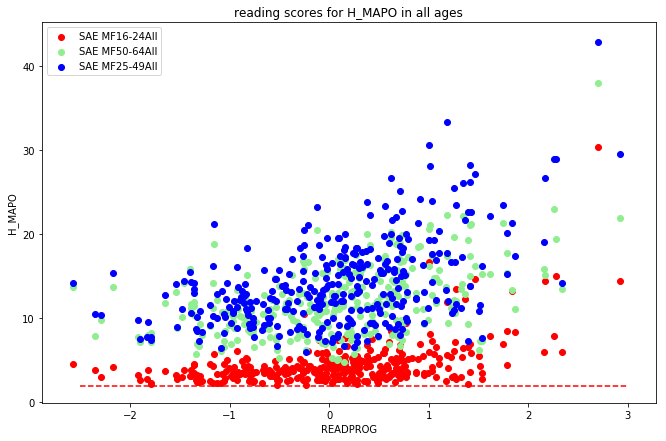

In [502]:
# plot pvrs_df data frame

colourMap_dict = {'MF16-24All':'red',
                  'MF25-49All':'blue',
                  'MF50-64All':'lightGreen'}

plt.subplots(figsize=(11, 7))

# loop through the different clusters:
for clstr in set(pvrs_df['SAE']):
    plt.scatter(pvrs_df['READPROG'][pvrs_df['SAE']==clstr],
                pvrs_df['H_MAPO'][pvrs_df['SAE']==clstr],
                color=colourMap_dict[clstr], label='SAE ' + clstr
               )

plt.legend()

plt.xlabel('READPROG')
plt.ylabel('H_MAPO')

plt.plot([-2.5,3],[2.0,2.0], "r--")

plt.title('reading scores for H_MAPO in all ages')
plt.show()

Graph 2.1 showing reading scores for H_MAPO in all ages

In [503]:
# Add the silhouette coefficients as a new column in the pvrs_df DataFrame:
pvrs_df['silhouette'] = silhouette_samples(pvrs_df[['READPROG', 'H_MAPO']], np.array(pvrs_df['SAE']))

pvrs_df.head()

,SAE,LA,H_MAPO,READPROG,silhouette
0,MF16-24All,Adur,2.7104,-0.125000,0.765864
1,MF16-24All,Allerdale,2.9845,0.444000,0.769472
2,MF16-24All,Amber Valley,3.1504,-0.566667,0.773676
3,MF16-24All,Arun,2.3072,-1.164286,0.718998
4,MF16-24All,Ashfield,2.6650,-1.337500,0.724099


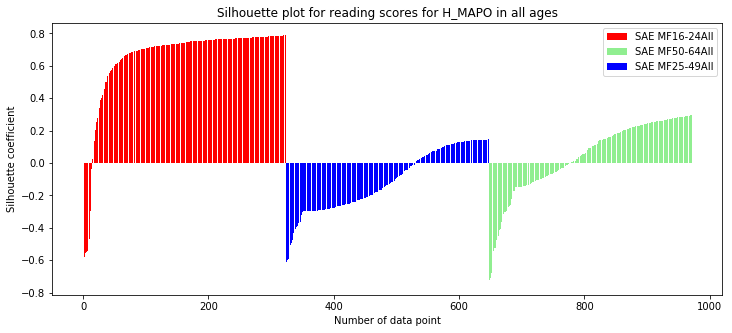

In [504]:
# Sort the DataFrame and plot the silhouette graph

pvrs_plt_df = pvrs_df.sort_values(['SAE', 'silhouette'])
pvrs_plt_df.index = list(range(len(pvrs_plt_df)))

plt.subplots(figsize=(12, 5))

for clstr in set(pvrs_plt_df['SAE']):
    plt.bar(pvrs_plt_df[pvrs_plt_df['SAE']==clstr].index,
            pvrs_plt_df[pvrs_plt_df['SAE']==clstr]['silhouette'], 
            color=colourMap_dict[clstr], label='SAE ' + clstr)

plt.title('Silhouette plot for reading scores for H_MAPO in all ages')

plt.legend()

plt.xlabel('Number of data point')
plt.ylabel('Silhouette coefficient')
#plt.ylim((0, 0.01))
plt.show()

Graph 2.2 showing Silhouette plot for reading scores for H_MAPO in all ages

Both graphs shows that there is too much difference between percentages in group 16-24 and groups 25-49,50-64
Thefore, it is advisable to claster each age group separatelly.
The same can be proved by calculating mean for each group and standard deviation

### Mean and standard deviation for each age group

In [505]:
# check mean and standard deviation for MF16-24All

mf1624_sd = filterGroups(pvrs_df, ['MF16-24All'], 'SAE')
mf1624_sd['READPROG'].describe()

324  rows filtered out of  972


count    324.000000
mean       0.076082
std        0.923739
min       -2.577778
25%       -0.548810
50%        0.128333
75%        0.673558
max        2.920833
Name: READPROG, dtype: float64

In [506]:
# check mean and standard deviation for MF25-49All

mf2549_sd = filterGroups(pvrs_df, ['MF25-49All'], 'SAE')
mf2549_sd['READPROG'].describe()

324  rows filtered out of  972


count    324.000000
mean       0.076082
std        0.923739
min       -2.577778
25%       -0.548810
50%        0.128333
75%        0.673558
max        2.920833
Name: READPROG, dtype: float64

In [507]:
# check mean and standard deviation for MF50-64All

mf5064_sd = filterGroups(pvrs_df, ['MF50-64All'], 'SAE')
mf5064_sd['READPROG'].describe()

324  rows filtered out of  972


count    324.000000
mean       0.076082
std        0.923739
min       -2.577778
25%       -0.548810
50%        0.128333
75%        0.673558
max        2.920833
Name: READPROG, dtype: float64

From the statistical outputs above we can see that, the standard deviation and medians for group MF25-49All and MF50-64All are much bigger than in group MF16-24All, which supports the fact that the youngest group deviate too much to cluster all three groups togather.

### Reading in group age 16-24<a name="Reading_MF16-24All"></a>
[top](#top)

In [508]:
# filter SAE to select only male/female in all group 16 - 24

fgrff = ['MF16-24All']
qt_dff = filterGroups(qt_df, fgrff, 'SAE')

qtrs_df = qt_dff[['SAE','LA', 'READPROG', 'H_MAPO']]
qtrs_df[['READPROG', 'H_MAPO']] = qtrs_df[['READPROG', 'H_MAPO']].astype(float)

qtrs_df.head(6)

12544  rows filtered out of  37649


,SAE,LA,READPROG,H_MAPO
0,MF16-24All,City of London,2.7,30.3125
3,MF16-24All,Camden,2.3,14.9784
6,MF16-24All,Camden,3.4,14.9784
9,MF16-24All,Camden,2.0,14.9784
12,MF16-24All,Camden,3.5,14.9784
15,MF16-24All,Camden,-0.3,14.9784


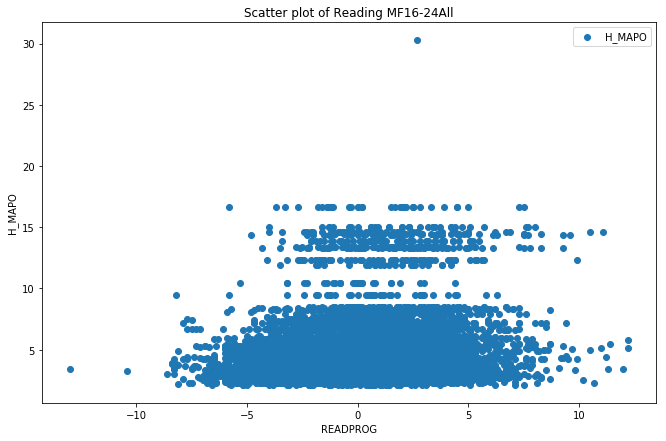

In [509]:
# plot the current data frame

plt.subplots(figsize=(11, 7))

plt.scatter(qtrs_df['READPROG'],
            qtrs_df['H_MAPO'])

plt.legend()

plt.xlabel('READPROG')
plt.ylabel('H_MAPO')

plt.title('Scatter plot of Reading MF16-24All')
plt.show()

Graph 2.3.1 showing Scatter plot of Reading MF16-24All

The graph shows two distict clusters. We can see a slight pattern here showing possible increase of scores with an incease of percentage groups. However, because of big variances in scores per each percentage group, I have to take a mean from reading and H_MAPO column.

In [510]:
# create a pivot table indexing local authority

ga_r_df = qtrs_df.pivot_table(qtrs_df, index=['LA'], aggfunc=np.mean)
ga_r_df.head()

,H_MAPO,READPROG
LA,,
Adur,2.7104,-0.125000
Allerdale,2.9845,0.444000
Amber Valley,3.1504,-0.566667
Arun,2.3072,-1.164286
Ashfield,2.6650,-1.337500


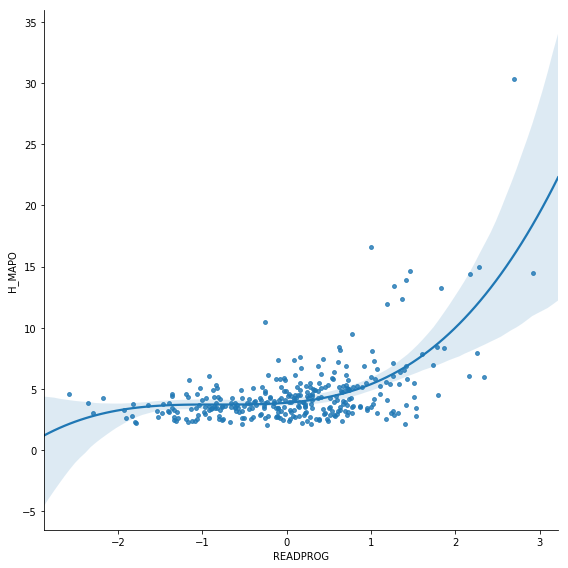

In [511]:
# produce a polynomial regression for scores in reading and H_MAPO group

sns.lmplot(x='READPROG', y='H_MAPO', data=ga_r_df, scatter_kws={'s':15}, order=3, size=8)
plt.show()

Graph 2.3.2 showing polynomial regression for scores in reading and H_MAPO group (age 16-24)

In [512]:
# Create an instance of the clusterer with k=2
kmeans3 = cluster.KMeans(n_clusters=3)

In [513]:
clusteringData_df = ga_r_df[['READPROG', 'H_MAPO']]
clusteringData_df.head()

,READPROG,H_MAPO
LA,,
Adur,-0.125000,2.7104
Allerdale,0.444000,2.9845
Amber Valley,-0.566667,3.1504
Arun,-1.164286,2.3072
Ashfield,-1.337500,2.6650


In [514]:
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df)

In [515]:
assignedClusters_clust.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 2, 2, 0, 0, 1, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2,
       2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 2, 2,
       2, 2, 0, 0, 0, 1, 0, 2, 2, 0, 2, 0, 0, 2, 0,

In [516]:
kmeans3.cluster_centers_

array([[-0.22988816,  3.43724821],
       [ 1.78452962, 15.47190909],
       [ 0.63500737,  5.98441011]])

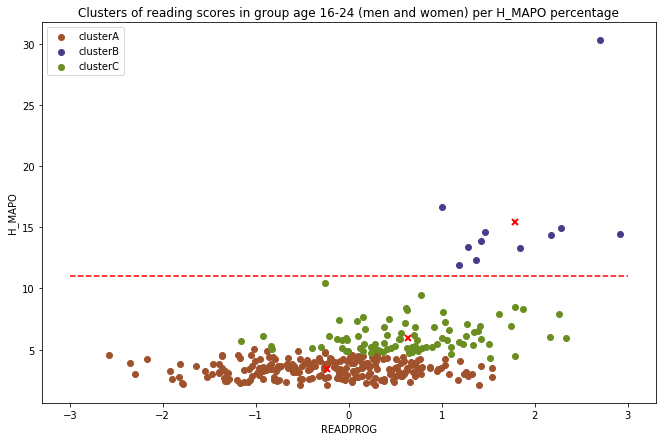

In [517]:
plt.subplots(figsize=(11, 7))

# Plot the data points which in the cluster labelled 'ClusterA'
plt.scatter(ga_r_df['READPROG'][assignedClusters_clust.labels_==0],
            ga_r_df['H_MAPO'][assignedClusters_clust.labels_==0],
            color='sienna', marker='o', label='clusterA')

# Plot the data points which in the cluster labelled 'ClusterB'
plt.scatter(ga_r_df['READPROG'][assignedClusters_clust.labels_==1],
            ga_r_df['H_MAPO'][assignedClusters_clust.labels_==1],
            color='darkslateblue', marker='o', label='clusterB')

#Plot the data points which in the cluster labelled 'ClusterC'
plt.scatter(ga_r_df['READPROG'][assignedClusters_clust.labels_==2],
            ga_r_df['H_MAPO'][assignedClusters_clust.labels_==2],
            color='olivedrab', marker='o', label='clusterC')
        
# Plot the data points which in the cluster labelled 'ClusterC'
# plt.scatter(ga_r_df['READPROG'][assignedClusters_clust.labels_==3],
#             ga_r_df['H_MAPO'][assignedClusters_clust.labels_==3],
#             color='blue', marker='o', label='clusterD')
        

# Plot each of the centroids:
for (cx, cy) in assignedClusters_clust.cluster_centers_:
    plt.plot(cx, cy, color='r', marker='x', mew=2)

plt.legend()


plt.xlabel('READPROG')
plt.ylabel('H_MAPO')

plt.title('Clusters of reading scores in group age 16-24 (men and women) per H_MAPO percentage')

plt.plot([-3,3],[11.0,11.0], "r--")
plt.show()

Graph 2.2.3 showing Clusters of reading scores in group age 16-24 (men and women) per H_MAPO percentage

The graph shows that in H_MAPO accounting for 11% and more, there are positive reading scores on average.

I shall check whether increasing clusters and changing initial centroids points has an effect on the results above

In [518]:
initialCentroids_df = pd.DataFrame({'READPROG':[0.0, 0.0, 0.0, 0.0, 0.0], 'H_MAPO':[5.0, 10.0, 15.0, 20.0, 25.0]}, columns=['READPROG', 'H_MAPO'])
#initialCentroids_df = pd.DataFrame({'READPROG':[-3, -2.5, -1], 'H_MAPO':[0.05, 0.07, 0.1]}, columns=['READPROG', 'H_MAPO'])
initialCentroids_df

,READPROG,H_MAPO
0,0.0,5.0
1,0.0,10.0
2,0.0,15.0
3,0.0,20.0
4,0.0,25.0


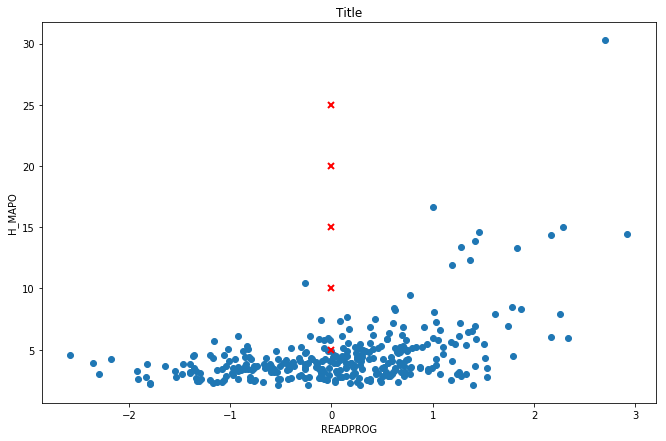

In [519]:
# check the initial values

plt.subplots(figsize=(11, 7))

plt.scatter(ga_r_df['READPROG'],
            ga_r_df['H_MAPO'])

plt.xlabel('READPROG')
plt.ylabel('H_MAPO')

plt.title('Title')

# Plot each of the centroids:
for i in initialCentroids_df.index:
    plt.plot(initialCentroids_df.loc[i]['READPROG'],
             initialCentroids_df.loc[i]['H_MAPO'],
             color='r', marker='x', mew=2)
    
plt.show()

In [520]:
kmeans5 = cluster.KMeans(n_clusters=5,
                         init=initialCentroids_df)

assignedClusters_clust = kmeans5.fit(ga_r_df[['READPROG', 'H_MAPO']])

assignedClusters_clust.labels_

C:\Users\patry\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 4, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 2, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 1, 1,
       1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0,

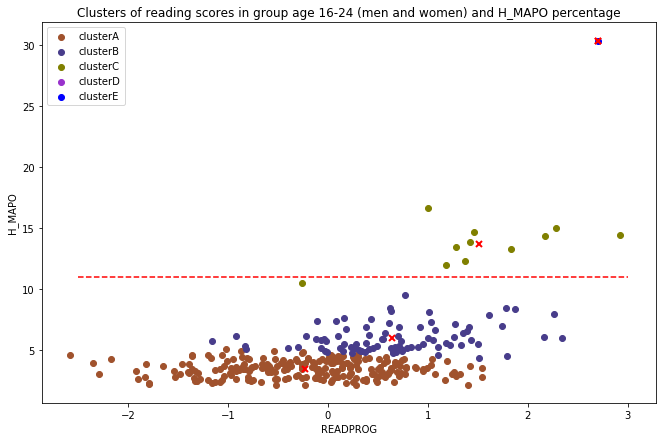

In [521]:
plt.subplots(figsize=(11, 7))

# Plot the data points which in the cluster labelled 'A'
plt.scatter(ga_r_df['READPROG'][assignedClusters_clust.labels_==0],
            ga_r_df['H_MAPO'][assignedClusters_clust.labels_==0],
            color='sienna', marker='o', label='clusterA')

# Plot the data points which in the cluster labelled 'B'
plt.scatter(ga_r_df['READPROG'][assignedClusters_clust.labels_==1],
            ga_r_df['H_MAPO'][assignedClusters_clust.labels_==1],
            color='darkslateblue', marker='o', label='clusterB')

# Plot the data points which in the cluster labelled 'C'
plt.scatter(ga_r_df['READPROG'][assignedClusters_clust.labels_==2],
            ga_r_df['H_MAPO'][assignedClusters_clust.labels_==2],
            color='olive', marker='o', label='clusterC')

# Plot the data points which in the cluster labelled 'D'
plt.scatter(ga_r_df['READPROG'][assignedClusters_clust.labels_==3],
            ga_r_df['H_MAPO'][assignedClusters_clust.labels_==3],
            color='darkorchid', marker='o', label='clusterD')

# Plot the data points which in the cluster labelled 'E'
plt.scatter(ga_r_df['READPROG'][assignedClusters_clust.labels_==4],
            ga_r_df['H_MAPO'][assignedClusters_clust.labels_==4],
            color='blue', marker='o', label='clusterE')

# Plot each of the centroids:
for (cx, cy) in assignedClusters_clust.cluster_centers_:
    plt.plot(cx, cy, color='r', marker='x', mew=2)

plt.legend()

plt.xlabel('READPROG')
plt.ylabel('H_MAPO')

plt.title('Clusters of reading scores in group age 16-24 (men and women) and H_MAPO percentage')

plt.plot([-2.5,3],[11.0,11.0], "r--")

plt.plot()
plt.show()

The graph above shows that increasing number of clusters and changing initial centroids does not have a major effect on the results achived with the default set up. The fourth and fifth cluster is asssigned to the outsiders in the 30% group.

### Reading in group age 25-49<a name="Reading_MF25-49All"></a>
[top](#top)

In [522]:
# filter SAE to select only male/female in all group 25 - 49

fgrff = ['MF25-49All']
qt_dff = filterGroups(qt_df, fgrff, 'SAE')

qtrs_df = qt_dff[['SAE','LA', 'READPROG', 'H_MAPO']]
qtrs_df[['READPROG', 'H_MAPO']] = qtrs_df[['READPROG', 'H_MAPO']].astype(float)

qtrs_df.head(6)

12544  rows filtered out of  37649


,SAE,LA,READPROG,H_MAPO
1,MF25-49All,City of London,2.7,42.7765
4,MF25-49All,Camden,2.3,28.8754
7,MF25-49All,Camden,3.4,28.8754
10,MF25-49All,Camden,2.0,28.8754
13,MF25-49All,Camden,3.5,28.8754
16,MF25-49All,Camden,-0.3,28.8754


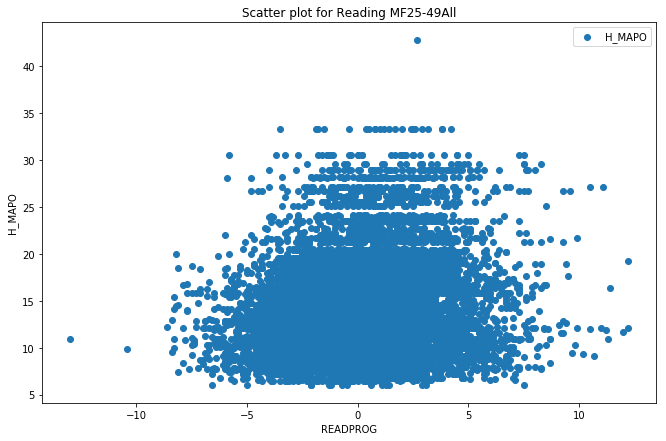

In [523]:
# plot the current data frame

plt.subplots(figsize=(11, 7))

plt.scatter(qtrs_df['READPROG'],
            qtrs_df['H_MAPO'])

plt.legend()

plt.xlabel('READPROG')
plt.ylabel('H_MAPO')

plt.title('Scatter plot for Reading MF25-49All')
plt.show()

The graph above shows even greater variations in reading scores in the particular percentage group.

It also confirms the fact that the 25-49 age group accounts for a greater proportion (up to 45%) than the younger group (up to 35%)

In [524]:
# create a pivot table indexing local authority

gb_r_df = qtrs_df.pivot_table(qtrs_df, index=['LA'], aggfunc=np.mean)
gb_r_df.head()

,H_MAPO,READPROG
LA,,
Adur,11.3666,-0.125000
Allerdale,9.3810,0.444000
Amber Valley,12.3237,-0.566667
Arun,10.2697,-1.164286
Ashfield,8.6657,-1.337500


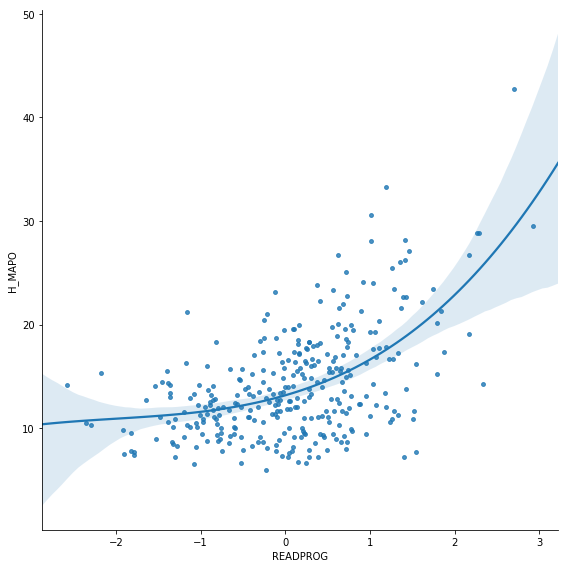

In [525]:
# produce a polynomial regression for scores in reading and H_MAPO group

sns.lmplot(x='READPROG', y='H_MAPO', data=gb_r_df, scatter_kws={'s':15}, order=3, size=8)
plt.show()

polynomial regression of scores in reading and H_MAPO group (age 25-49)

In [526]:
# Create an instance of the clusterer with k=2
#kmeans2 = cluster.KMeans(n_clusters=2, n_init=50, max_iter=500, precompute_distances=True, n_jobs=-1)
kmeans3 = cluster.KMeans(n_clusters=3)

In [527]:
clusteringData_gb_r_df = gb_r_df[['READPROG', 'H_MAPO']]
clusteringData_gb_r_df.head()

,READPROG,H_MAPO
LA,,
Adur,-0.125000,11.3666
Allerdale,0.444000,9.3810
Amber Valley,-0.566667,12.3237
Arun,-1.164286,10.2697
Ashfield,-1.337500,8.6657


In [528]:
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_gb_r_df_clust = kmeans3.fit(clusteringData_gb_r_df)

In [529]:
assignedClusters_gb_r_df_clust.labels_

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 1, 1,
       0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 1, 2, 0, 0, 0, 2,
       0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0,
       0, 0, 0, 2, 0, 1, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       2, 1, 2, 0, 2, 1, 2, 2, 0, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 2, 2, 0, 0,
       0, 2, 0, 2, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 2, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 1, 1, 2, 2, 2, 0, 0, 0, 2, 2,
       1, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0,
       2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 1, 2, 2,
       2, 1, 0, 0, 0, 1, 2, 1, 2, 0, 1, 2, 0, 2, 2,

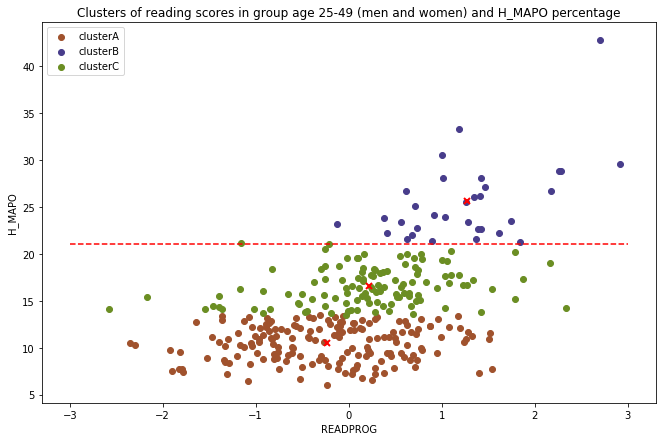

In [530]:
plt.subplots(figsize=(11, 7))

# Plot the data points which in the cluster labelled 'ClusterA'
plt.scatter(gb_r_df['READPROG'][assignedClusters_gb_r_df_clust.labels_==0],
            gb_r_df['H_MAPO'][assignedClusters_gb_r_df_clust.labels_==0],
            color='sienna', marker='o', label='clusterA')

# Plot the data points which in the cluster labelled 'ClusterB'
plt.scatter(gb_r_df['READPROG'][assignedClusters_gb_r_df_clust.labels_==1],
            gb_r_df['H_MAPO'][assignedClusters_gb_r_df_clust.labels_==1],
            color='darkslateblue', marker='o', label='clusterB')

#Plot the data points which in the cluster labelled 'ClusterC'
plt.scatter(gb_r_df['READPROG'][assignedClusters_gb_r_df_clust.labels_==2],
            gb_r_df['H_MAPO'][assignedClusters_gb_r_df_clust.labels_==2],
            color='olivedrab', marker='o', label='clusterC')
        
# Plot the data points which in the cluster labelled 'ClusterC'
# plt.scatter(gb_r_df['READPROG'][assignedClusters_clust.labels_==3],
#             gb_r_df['H_MAPO'][assignedClusters_clust.labels_==3],
#             color='blue', marker='o', label='clusterD')
        

# Plot each of the centroids:
for (cx, cy) in assignedClusters_gb_r_df_clust.cluster_centers_:
    plt.plot(cx, cy, color='r', marker='x', mew=2)

plt.legend()


plt.xlabel('READPROG')
plt.ylabel('H_MAPO')

plt.title('Clusters of reading scores in group age 25-49 (men and women) and H_MAPO percentage')

plt.plot([-3,3],[21.1, 21.1], "r--")
plt.show()

The graph above shows that the H_MAPO accounting for 21.6% and more coresponds to positive reading scores on avarage in majority cases.

It seems that the algorithm ties to capture negative scores for 21.4% percentage. This is actually not what happens here (the highest blue dot is slightly lower than lowest green data point, so the line is somewhere between blue and green data points). However, it is possible to capture both positive and negative values; this is due to the fact that the algoritm does not know that we are more interested in positive reading values, so this fact has to be considered when interpreting all graphs in this section.

In [531]:
# applying silhouette coefficients and visualising the result.

# res = pd.DataFrame([gb_r_df.index, assignedClusters_clust.labels_]).T
# res.rename(columns={0:'LA_',1:'Cluster'}, inplace=True)

# gb_r_df_nonpiv = gb_r_df
# gb_r_df_nonpiv['LA'] = gb_r_df_nonpiv.index
# gb_r_df_nonpiv.unstack().reset_index()
# gb_r_df_nonpiv.head()

# res_gb_r_df = res.merge(gb_r_df_nonpiv, on='LA')
# res.head()

### Reading in group age 50-64<a name="Reading_MF50-64All"></a>
[top](#top)

In [532]:
# filter SAE to select only male/female in all group 50 - 64

fgrff = ['MF50-64All']
qt_dff = filterGroups(qt_df, fgrff, 'SAE')

qtrs_df = qt_dff[['SAE','LA', 'READPROG', 'H_MAPO']]
qtrs_df[['READPROG', 'H_MAPO']] = qtrs_df[['READPROG', 'H_MAPO']].astype(float)

qtrs_df.head(6)

12544  rows filtered out of  37649


,SAE,LA,READPROG,H_MAPO
2,MF50-64All,City of London,2.7,37.8855
5,MF50-64All,Camden,2.3,19.3776
8,MF50-64All,Camden,3.4,19.3776
11,MF50-64All,Camden,2.0,19.3776
14,MF50-64All,Camden,3.5,19.3776
17,MF50-64All,Camden,-0.3,19.3776


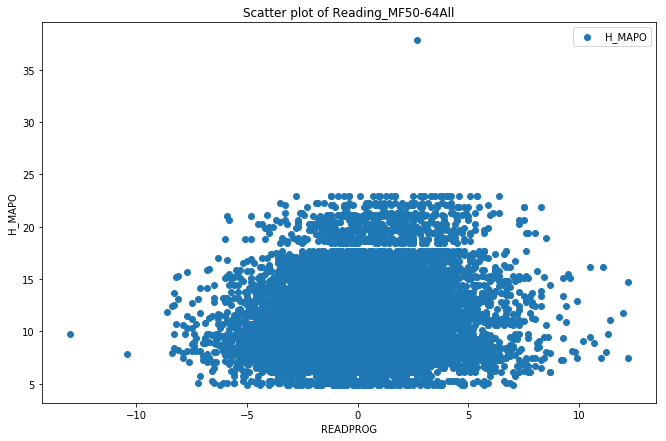

In [533]:
# plot the current data frame

plt.subplots(figsize=(11, 7))

plt.scatter(qtrs_df['READPROG'],
            qtrs_df['H_MAPO'])

plt.legend()

plt.xlabel('READPROG')
plt.ylabel('H_MAPO')

plt.title('Scatter plot of Reading_MF50-64All')
plt.show()

In [534]:
# create a pivot table indexing local authority

gc_r_df = qtrs_df.pivot_table(qtrs_df, index=['LA'], aggfunc=np.mean)
gc_r_df.head()

,H_MAPO,READPROG
LA,,
Adur,9.4876,-0.125000
Allerdale,9.2943,0.444000
Amber Valley,10.4004,-0.566667
Arun,11.2314,-1.164286
Ashfield,5.7867,-1.337500


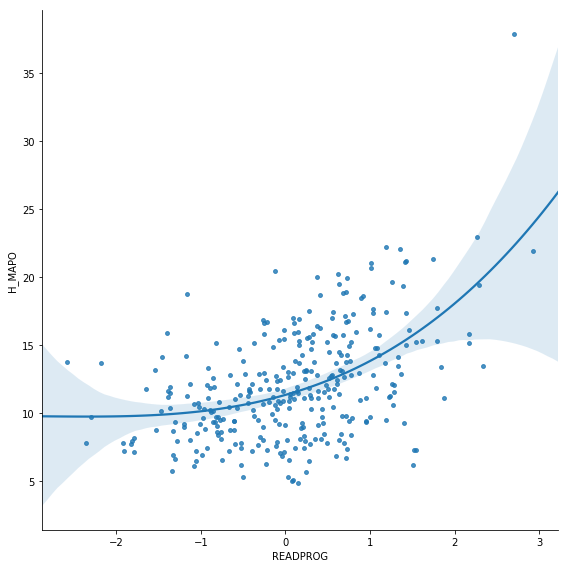

In [535]:
# produce a polynomial regression for scores in reading and H_MAPO group

sns.lmplot(x='READPROG', y='H_MAPO', data=gc_r_df, scatter_kws={'s':15}, order=3, size=8)
plt.show()

In [536]:
# Create an instance of the clusterer with k=2
kmeans4 = cluster.KMeans(n_clusters=4)

In [537]:
clusteringData_df = gc_r_df[['READPROG', 'H_MAPO']]
clusteringData_df.head()

,READPROG,H_MAPO
LA,,
Adur,-0.125000,9.4876
Allerdale,0.444000,9.2943
Amber Valley,-0.566667,10.4004
Arun,-1.164286,11.2314
Ashfield,-1.337500,5.7867


In [538]:
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_clust = kmeans4.fit(clusteringData_df)

In [539]:
assignedClusters_clust.labels_

array([1, 1, 0, 0, 1, 0, 3, 0, 1, 3, 1, 1, 1, 3, 1, 3, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 3, 1, 0, 1, 0, 3, 3, 0, 0, 3, 3, 1, 0, 1, 0, 0, 2, 2,
       1, 0, 1, 1, 0, 0, 3, 3, 0, 3, 3, 1, 3, 2, 0, 0, 2, 0, 1, 1, 1, 3,
       1, 1, 0, 1, 0, 3, 1, 1, 3, 0, 3, 1, 1, 1, 3, 0, 0, 3, 3, 3, 1, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 3, 1, 0, 3, 1, 1, 0, 3, 1, 0, 1, 1, 1, 1,
       0, 2, 0, 1, 3, 3, 3, 3, 1, 3, 3, 2, 1, 1, 0, 1, 0, 3, 0, 0, 0, 3,
       0, 3, 1, 1, 1, 3, 2, 0, 1, 1, 3, 0, 1, 3, 0, 0, 1, 3, 0, 3, 1, 1,
       1, 0, 0, 3, 1, 1, 1, 0, 0, 3, 0, 0, 3, 1, 3, 2, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 3, 0, 1, 1, 3, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 2, 1, 1, 1,
       0, 0, 0, 0, 3, 0, 1, 3, 3, 2, 0, 1, 0, 0, 0, 1, 0, 3, 2, 0, 3, 0,
       1, 1, 1, 0, 0, 0, 3, 0, 1, 0, 1, 3, 2, 2, 0, 0, 3, 1, 0, 3, 0, 3,
       2, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 3, 0, 0, 3, 1, 1, 3, 3, 0, 1,
       2, 0, 1, 0, 1, 1, 3, 0, 0, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 0, 3, 3,
       3, 2, 1, 1, 1, 3, 0, 3, 0, 1, 2, 3, 1, 3, 3,

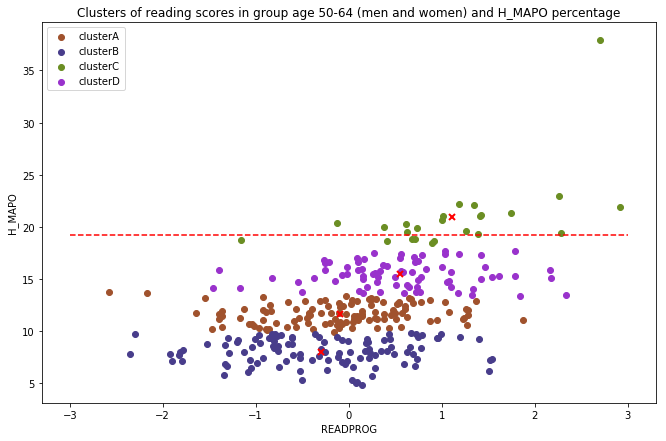

In [540]:
plt.subplots(figsize=(11, 7))

# Plot the data points which in the cluster labelled 'ClusterA'
plt.scatter(gc_r_df['READPROG'][assignedClusters_clust.labels_==0],
            gc_r_df['H_MAPO'][assignedClusters_clust.labels_==0],
            color='sienna', marker='o', label='clusterA')

# Plot the data points which in the cluster labelled 'ClusterB'
plt.scatter(gc_r_df['READPROG'][assignedClusters_clust.labels_==1],
            gc_r_df['H_MAPO'][assignedClusters_clust.labels_==1],
            color='darkslateblue', marker='o', label='clusterB')

#Plot the data points which in the cluster labelled 'ClusterC'
plt.scatter(gc_r_df['READPROG'][assignedClusters_clust.labels_==2],
            gc_r_df['H_MAPO'][assignedClusters_clust.labels_==2],
            color='olivedrab', marker='o', label='clusterC')
        
# Plot the data points which in the cluster labelled 'ClusterC'
plt.scatter(gc_r_df['READPROG'][assignedClusters_clust.labels_==3],
            gc_r_df['H_MAPO'][assignedClusters_clust.labels_==3],
            color='darkorchid', marker='o', label='clusterD')

# Plot the data points which in the cluster labelled 'ClusterC'
# plt.scatter(gc_r_df['READPROG'][assignedClusters_clust.labels_==4],
#             gc_r_df['H_MAPO'][assignedClusters_clust.labels_==4],
#             color='tomato', marker='o', label='clusterD')
        

# Plot each of the centroids:
for (cx, cy) in assignedClusters_clust.cluster_centers_:
    plt.plot(cx, cy, color='r', marker='x', mew=2)

plt.legend()


plt.xlabel('READPROG')
plt.ylabel('H_MAPO')

plt.title('Clusters of reading scores in group age 50-64 (men and women) and H_MAPO percentage')

plt.plot([-3,3],[19.2,19.2], "r--")
plt.show()

The graph shows that H_MAPO accounting for over 19.2% have a positive reading scores on average, in most cases.

The algorithm captures at least two negative values in clusterD, and any extra cluster would not change it wihout implementing custom distances (not covered in this module). Thefore we have to move all positive reading values to from clusterD to clusterA once new data frames are created from the clusters.

### Writing in group age 16-24<a name="Writing_MF16-24All"></a>
[top](#top)

In [541]:
# filter SAE to select only male/female in all group 16 - 24

fgrff = ['MF16-24All']
qt_dff = filterGroups(qt_df, fgrff, 'SAE')

qtrs_df = qt_dff[['SAE','LA', 'WRITPROG', 'H_MAPO']]
qtrs_df[['WRITPROG', 'H_MAPO']] = qtrs_df[['WRITPROG', 'H_MAPO']].astype(float)

qtrs_df.head(6)

12544  rows filtered out of  37649


,SAE,LA,WRITPROG,H_MAPO
0,MF16-24All,City of London,2.2,30.3125
3,MF16-24All,Camden,1.4,14.9784
6,MF16-24All,Camden,2.2,14.9784
9,MF16-24All,Camden,1.4,14.9784
12,MF16-24All,Camden,0.4,14.9784
15,MF16-24All,Camden,-4.7,14.9784


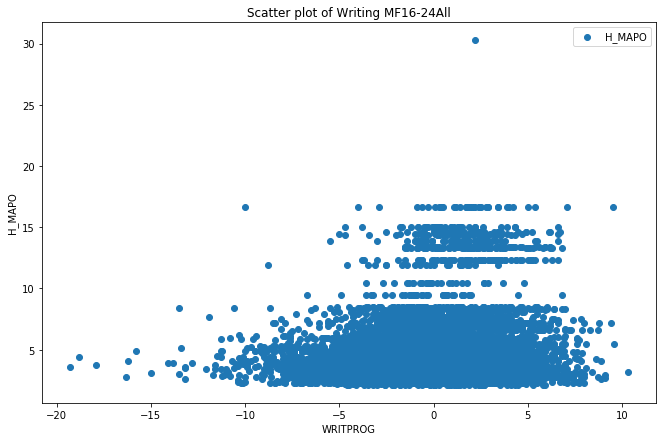

In [542]:
# plot the current data frame

plt.subplots(figsize=(11, 7))

plt.scatter(qtrs_df['WRITPROG'],
            qtrs_df['H_MAPO'])

plt.legend()

plt.xlabel('WRITPROG')
plt.ylabel('H_MAPO')

plt.title('Scatter plot of Writing MF16-24All')
plt.show()

In [543]:
# create a pivot table indexing local authority

ga_w_df = qtrs_df.pivot_table(qtrs_df, index=['LA'], aggfunc=np.mean)
ga_w_df.head()

,H_MAPO,WRITPROG
LA,,
Adur,2.7104,-1.966667
Allerdale,2.9845,-1.144000
Amber Valley,3.1504,0.533333
Arun,2.3072,-4.335714
Ashfield,2.6650,-0.843750


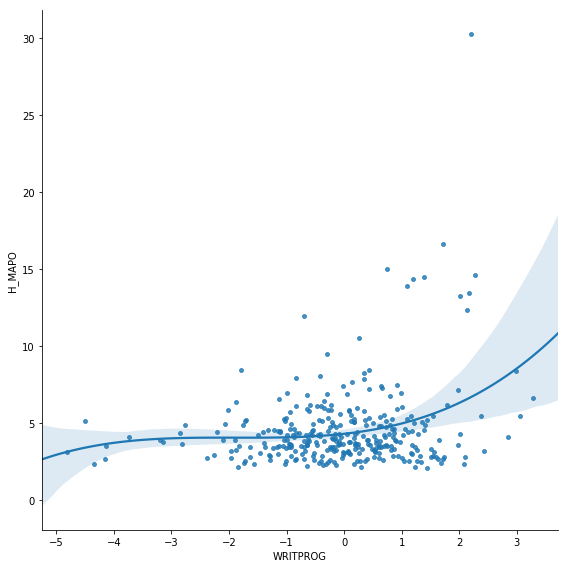

In [544]:
# produce a polynomial regression for scores in reading and H_MAPO group

sns.lmplot(x='WRITPROG', y='H_MAPO', data=ga_w_df, scatter_kws={'s':15}, order=3, size=8)
plt.show()

In [545]:
# Create an instance of the clusterer with k=2
#kmeans2 = cluster.KMeans(n_clusters=2, n_init=50, max_iter=500, precompute_distances=True, n_jobs=-1)
kmeans2 = cluster.KMeans(n_clusters=2)

In [546]:
clusteringData_df = ga_w_df[['WRITPROG', 'H_MAPO']]
clusteringData_df.head()

,WRITPROG,H_MAPO
LA,,
Adur,-1.966667,2.7104
Allerdale,-1.144000,2.9845
Amber Valley,0.533333,3.1504
Arun,-4.335714,2.3072
Ashfield,-0.843750,2.6650


In [547]:
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_clust = kmeans2.fit(clusteringData_df)

In [548]:
assignedClusters_clust.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

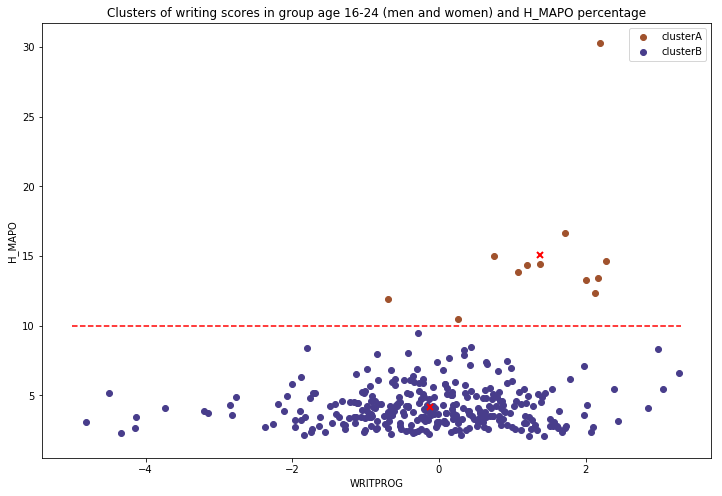

In [549]:
plt.subplots(figsize=(12, 8))

# Plot the data points which in the cluster labelled 'ClusterA'
plt.scatter(ga_w_df['WRITPROG'][assignedClusters_clust.labels_==0],
            ga_w_df['H_MAPO'][assignedClusters_clust.labels_==0],
            color='sienna', marker='o', label='clusterA')

# Plot the data points which in the cluster labelled 'ClusterB'
plt.scatter(ga_w_df['WRITPROG'][assignedClusters_clust.labels_==1],
            ga_w_df['H_MAPO'][assignedClusters_clust.labels_==1],
            color='darkslateblue', marker='o', label='clusterB')

# Plot the data points which in the cluster labelled 'ClusterC'
# plt.scatter(ga_w_df['WRITPROG'][assignedClusters_clust.labels_==2],
#             ga_w_df['H_MAPO'][assignedClusters_clust.labels_==2],
#             color='olivedrab', marker='o', label='clusterC')
        
# Plot the data points which in the cluster labelled 'ClusterC'
# plt.scatter(ga_w_df['WRITPROG'][assignedClusters_clust.labels_==3],
#             ga_w_df['H_MAPO'][assignedClusters_clust.labels_==3],
#             color='blue', marker='o', label='clusterD')
        

# Plot each of the centroids:
for (cx, cy) in assignedClusters_clust.cluster_centers_:
    plt.plot(cx, cy, color='r', marker='x', mew=2)

plt.legend()


plt.xlabel('WRITPROG')
plt.ylabel('H_MAPO')

plt.title('Clusters of writing scores in group age 16-24 (men and women) and H_MAPO percentage')

plt.plot([-5,3.3],[10,10], "r--")
plt.show()

The graph shows that the H_MAPO accounting for 10% and more has a positive writing values on average in most cases.

### Writing in group age 25-49<a name="Writing_MF25-49All"></a>
[top](#top)

In [550]:
# filter SAE to select only male/female in all group 16 - 24

fgrff = ['MF25-49All']
qt_dff = filterGroups(qt_df, fgrff, 'SAE')

qtrs_df = qt_dff[['SAE','LA', 'WRITPROG', 'H_MAPO']]
qtrs_df[['WRITPROG', 'H_MAPO']] = qtrs_df[['WRITPROG', 'H_MAPO']].astype(float)

qtrs_df.head(6)

12544  rows filtered out of  37649


,SAE,LA,WRITPROG,H_MAPO
1,MF25-49All,City of London,2.2,42.7765
4,MF25-49All,Camden,1.4,28.8754
7,MF25-49All,Camden,2.2,28.8754
10,MF25-49All,Camden,1.4,28.8754
13,MF25-49All,Camden,0.4,28.8754
16,MF25-49All,Camden,-4.7,28.8754


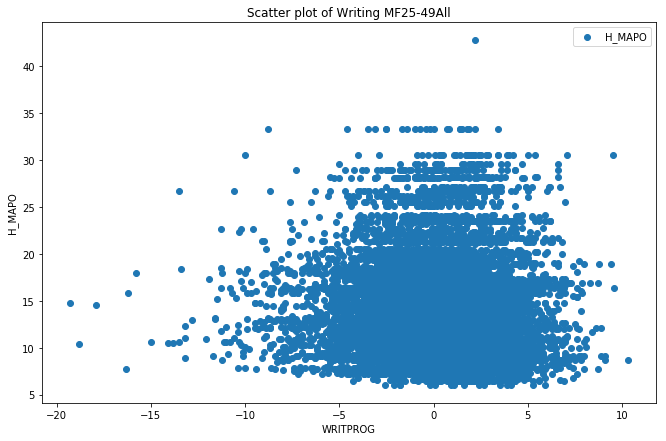

In [551]:
# plot the current data frame

plt.subplots(figsize=(11, 7))

plt.scatter(qtrs_df['WRITPROG'],
            qtrs_df['H_MAPO'])

plt.legend()

plt.xlabel('WRITPROG')
plt.ylabel('H_MAPO')

plt.title('Scatter plot of Writing MF25-49All')
plt.show()

In [552]:
# create a pivot table indexing local authority

gb_w_df = qtrs_df.pivot_table(qtrs_df, index=['LA'], aggfunc=np.mean)
gb_w_df.head()

,H_MAPO,WRITPROG
LA,,
Adur,11.3666,-1.966667
Allerdale,9.3810,-1.144000
Amber Valley,12.3237,0.533333
Arun,10.2697,-4.335714
Ashfield,8.6657,-0.843750


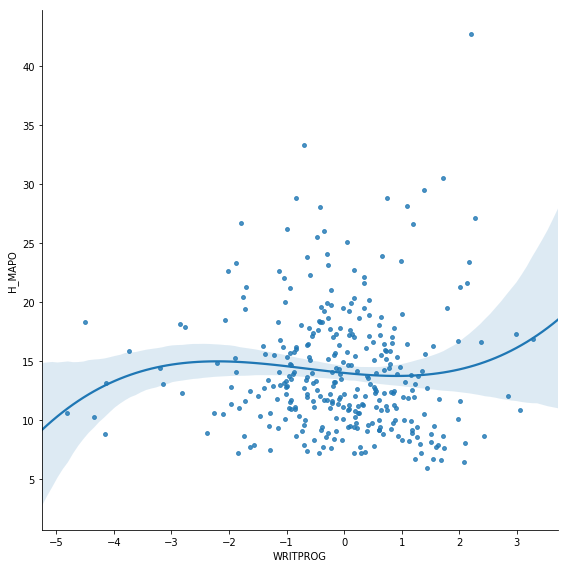

In [553]:
# produce a polynomial regression for scores in reading and H_MAPO group

sns.lmplot(x='WRITPROG', y='H_MAPO', data=gb_w_df, scatter_kws={'s':15}, order=3, size=8)
plt.show()

In [554]:
# Create an instance of the clusterer with k=2
#kmeans2 = cluster.KMeans(n_clusters=2, n_init=50, max_iter=500, precompute_distances=True, n_jobs=-1)
kmeans4 = cluster.KMeans(n_clusters=4)

In [555]:
clusteringData_df = gb_w_df[['WRITPROG', 'H_MAPO']]
clusteringData_df.head()

,WRITPROG,H_MAPO
LA,,
Adur,-1.966667,11.3666
Allerdale,-1.144000,9.3810
Amber Valley,0.533333,12.3237
Arun,-4.335714,10.2697
Ashfield,-0.843750,8.6657


In [556]:
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_clust = kmeans4.fit(clusteringData_df)

In [557]:
assignedClusters_clust.labels_

array([0, 2, 0, 2, 2, 0, 3, 0, 2, 3, 2, 2, 0, 3, 2, 3, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 0, 3, 2, 0, 2, 0, 3, 3, 3, 0, 3, 3, 2, 3, 2, 0, 0, 1, 1,
       2, 0, 2, 2, 0, 0, 3, 3, 0, 3, 0, 2, 0, 3, 0, 0, 1, 0, 0, 2, 2, 3,
       2, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 2, 2, 2, 3, 3, 0, 0, 3, 3, 2, 0,
       0, 2, 2, 3, 2, 1, 0, 3, 3, 0, 0, 3, 2, 2, 2, 3, 0, 0, 2, 2, 2, 2,
       3, 1, 3, 2, 0, 1, 3, 3, 2, 3, 3, 1, 2, 2, 2, 0, 2, 3, 0, 0, 0, 3,
       3, 3, 2, 2, 2, 1, 1, 0, 2, 2, 1, 0, 2, 3, 0, 3, 2, 0, 3, 0, 2, 0,
       2, 0, 0, 3, 0, 2, 2, 0, 0, 3, 2, 0, 3, 2, 3, 3, 0, 0, 3, 0, 2, 2,
       2, 2, 2, 3, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 1, 2, 2, 2,
       0, 0, 0, 2, 3, 3, 2, 3, 0, 1, 2, 2, 0, 0, 2, 2, 0, 3, 1, 0, 0, 2,
       0, 2, 2, 2, 2, 0, 3, 0, 2, 0, 0, 3, 3, 1, 0, 3, 0, 2, 0, 2, 0, 3,
       3, 0, 0, 0, 2, 0, 0, 3, 0, 1, 0, 2, 0, 2, 0, 3, 2, 2, 3, 0, 0, 2,
       3, 0, 2, 0, 2, 2, 3, 0, 0, 2, 2, 3, 0, 2, 3, 2, 0, 2, 2, 1, 3, 3,
       3, 3, 2, 2, 0, 1, 3, 1, 3, 2, 3, 0, 2, 3, 3,

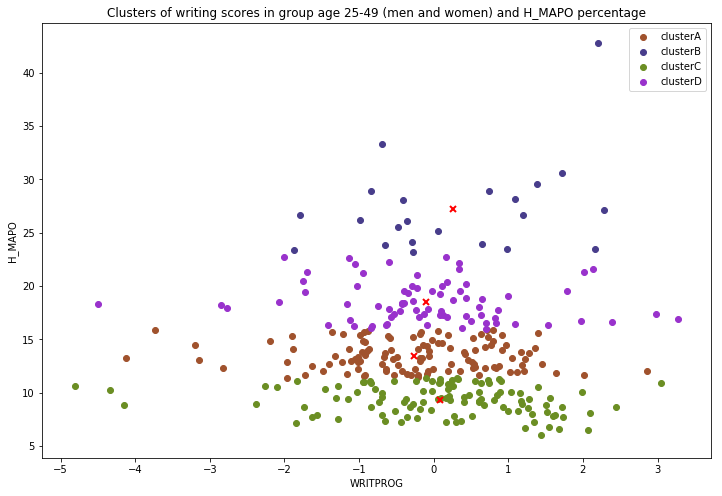

In [558]:
plt.subplots(figsize=(12, 8))

# Plot the data points which in the cluster labelled 'ClusterA'
plt.scatter(gb_w_df['WRITPROG'][assignedClusters_clust.labels_==0],
            gb_w_df['H_MAPO'][assignedClusters_clust.labels_==0],
            color='sienna', marker='o', label='clusterA')

# Plot the data points which in the cluster labelled 'ClusterB'
plt.scatter(gb_w_df['WRITPROG'][assignedClusters_clust.labels_==1],
            gb_w_df['H_MAPO'][assignedClusters_clust.labels_==1],
            color='darkslateblue', marker='o', label='clusterB')

#Plot the data points which in the cluster labelled 'ClusterC'
plt.scatter(gb_w_df['WRITPROG'][assignedClusters_clust.labels_==2],
            gb_w_df['H_MAPO'][assignedClusters_clust.labels_==2],
            color='olivedrab', marker='o', label='clusterC')
        
#Plot the data points which in the cluster labelled 'ClusterC'
plt.scatter(gb_w_df['WRITPROG'][assignedClusters_clust.labels_==3],
            gb_w_df['H_MAPO'][assignedClusters_clust.labels_==3],
            color='darkorchid', marker='o', label='clusterD')
        

# Plot each of the centroids:
for (cx, cy) in assignedClusters_clust.cluster_centers_:
    plt.plot(cx, cy, color='r', marker='x', mew=2)

plt.legend()


plt.xlabel('WRITPROG')
plt.ylabel('H_MAPO')

plt.title('Clusters of writing scores in group age 25-49 (men and women) and H_MAPO percentage')

plt.show()

The graph shows that both negative and positive writing scores are widely distributed in clusterD, clusterC and clusterA with smaller distribution in clasterB, but being a normal distribution with lambda=0.

This can be further checked by plotting distribution for the current data frame, as seen below

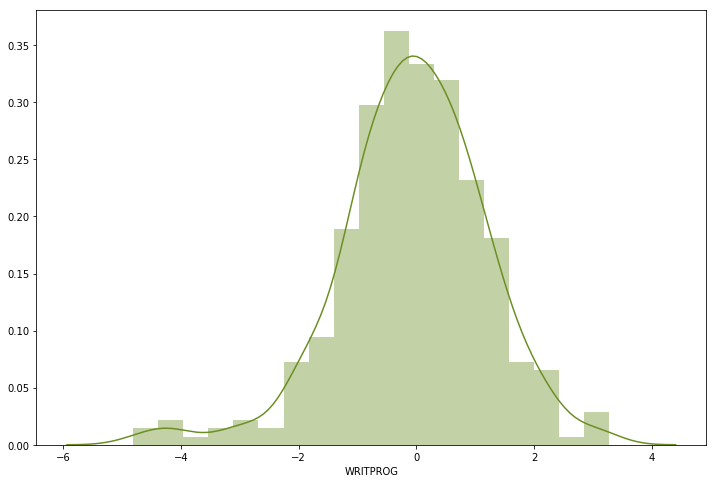

In [559]:
gb_w_plt = sns.distplot(gb_w_df['WRITPROG'], label='WRITPROG', color='olivedrab')
plt.show()

### Writing in group age 50-64<a name="Writing_MF50-64All"></a>
[top](#top)

In [560]:
# filter SAE to select only male/female in all group 16 - 24

fgrff = ['MF50-64All']
qt_dff = filterGroups(qt_df, fgrff, 'SAE')

qtrs_df = qt_dff[['SAE','LA', 'WRITPROG', 'H_MAPO']]
qtrs_df[['WRITPROG', 'H_MAPO']] = qtrs_df[['WRITPROG', 'H_MAPO']].astype(float)

qtrs_df.head(6)

12544  rows filtered out of  37649


,SAE,LA,WRITPROG,H_MAPO
2,MF50-64All,City of London,2.2,37.8855
5,MF50-64All,Camden,1.4,19.3776
8,MF50-64All,Camden,2.2,19.3776
11,MF50-64All,Camden,1.4,19.3776
14,MF50-64All,Camden,0.4,19.3776
17,MF50-64All,Camden,-4.7,19.3776


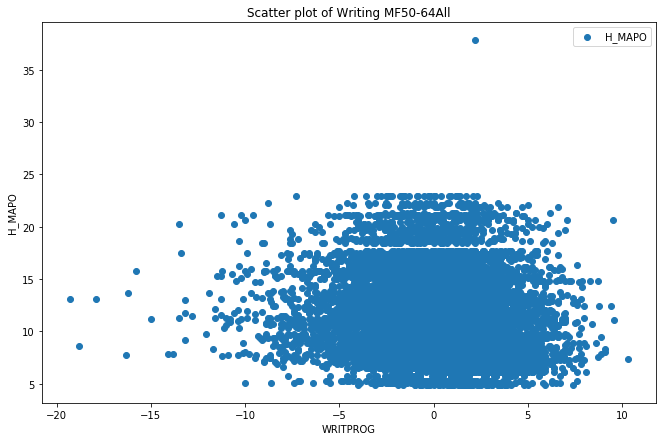

In [561]:
# plot the current data frame

plt.subplots(figsize=(11, 7))

plt.scatter(qtrs_df['WRITPROG'],
            qtrs_df['H_MAPO'])

plt.legend()

plt.xlabel('WRITPROG')
plt.ylabel('H_MAPO')

plt.title('Scatter plot of Writing MF50-64All')
plt.show()

In [562]:
# create a pivot table indexing local authority

gc_w_df = qtrs_df.pivot_table(qtrs_df, index=['LA'], aggfunc=np.mean)
gc_w_df.head()

,H_MAPO,WRITPROG
LA,,
Adur,9.4876,-1.966667
Allerdale,9.2943,-1.144000
Amber Valley,10.4004,0.533333
Arun,11.2314,-4.335714
Ashfield,5.7867,-0.843750


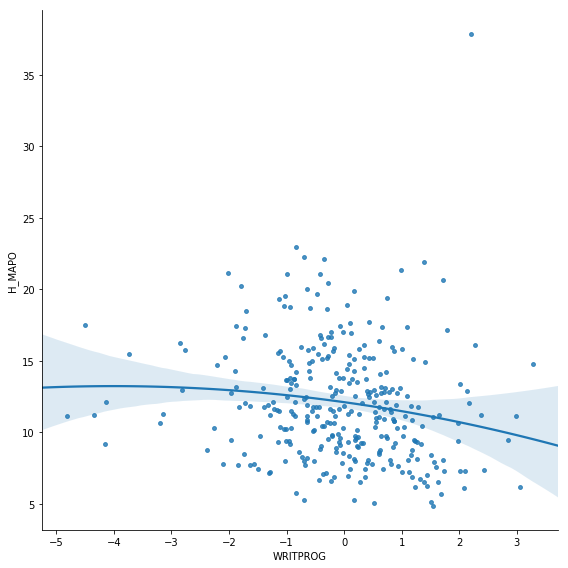

In [563]:
# produce a polynomial regression for scores in reading and H_MAPO group

sns.lmplot(x='WRITPROG', y='H_MAPO', data=gc_w_df, scatter_kws={'s':15}, order=2, size=8)
plt.show()

The graph shows that there is a slight decrease of writing scores on average if the percentage of H_MAPO increases. This pattern stops at around -1 writing score, where the percentage group for the rest of negative scores narrows rapidally to a range of between 10% and 18%

In [564]:
# Create an instance of the clusterer with k=2
#kmeans2 = cluster.KMeans(n_clusters=2, n_init=50, max_iter=500, precompute_distances=True, n_jobs=-1)
kmeans4 = cluster.KMeans(n_clusters=4)

In [565]:
clusteringData_df = gc_w_df[['WRITPROG', 'H_MAPO']]
clusteringData_df.head()

,WRITPROG,H_MAPO
LA,,
Adur,-1.966667,9.4876
Allerdale,-1.144000,9.2943
Amber Valley,0.533333,10.4004
Arun,-4.335714,11.2314
Ashfield,-0.843750,5.7867


In [566]:
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_clust = kmeans4.fit(clusteringData_df)

In [567]:
assignedClusters_clust.labels_

array([2, 2, 0, 0, 2, 0, 3, 0, 2, 3, 2, 2, 2, 3, 2, 3, 3, 2, 2, 0, 2, 2,
       2, 2, 2, 0, 3, 2, 0, 2, 0, 3, 3, 0, 0, 3, 3, 2, 0, 2, 0, 0, 1, 1,
       2, 0, 2, 2, 3, 0, 3, 3, 0, 3, 3, 2, 3, 1, 0, 0, 1, 0, 2, 2, 2, 3,
       2, 2, 0, 2, 0, 3, 2, 2, 3, 0, 3, 2, 2, 2, 3, 0, 0, 3, 3, 3, 2, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 3, 2, 0, 3, 2, 2, 0, 3, 2, 0, 2, 2, 2, 2,
       0, 1, 0, 2, 3, 3, 3, 3, 2, 3, 3, 1, 2, 2, 0, 2, 0, 3, 0, 0, 0, 3,
       0, 3, 2, 2, 2, 3, 1, 0, 2, 2, 3, 0, 2, 0, 0, 0, 2, 3, 0, 3, 2, 2,
       2, 0, 0, 3, 2, 2, 2, 0, 0, 3, 0, 0, 3, 2, 3, 1, 0, 0, 0, 0, 2, 2,
       0, 0, 2, 3, 0, 2, 2, 3, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 2,
       0, 0, 0, 0, 3, 0, 2, 3, 3, 1, 0, 2, 0, 0, 0, 2, 0, 3, 1, 0, 3, 0,
       2, 2, 2, 0, 0, 0, 3, 0, 2, 0, 2, 3, 1, 1, 0, 0, 0, 2, 0, 0, 0, 3,
       1, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 3, 0, 0, 3, 2, 2, 3, 3, 0, 2,
       1, 0, 2, 0, 2, 2, 3, 0, 0, 2, 2, 3, 3, 2, 3, 2, 3, 2, 2, 0, 3, 3,
       3, 1, 2, 2, 2, 3, 0, 3, 0, 2, 1, 3, 0, 3, 3,

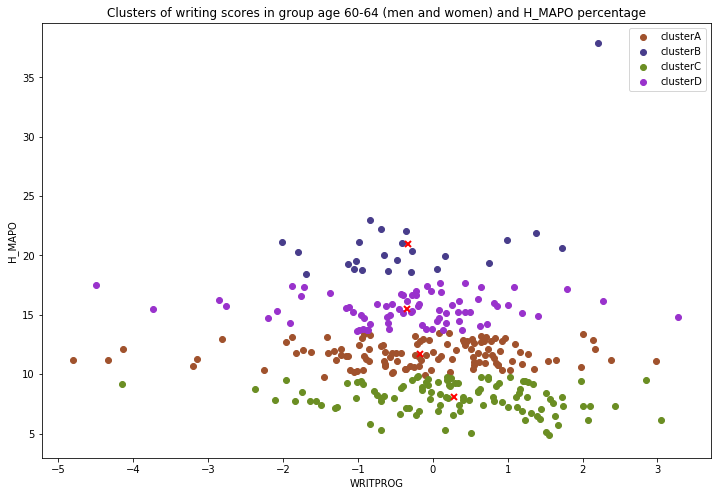

In [568]:
plt.subplots(figsize=(12, 8))

# Plot the data points which in the cluster labelled 'ClusterA'
plt.scatter(gc_w_df['WRITPROG'][assignedClusters_clust.labels_==0],
            gc_w_df['H_MAPO'][assignedClusters_clust.labels_==0],
            color='sienna', marker='o', label='clusterA')

# Plot the data points which in the cluster labelled 'ClusterB'
plt.scatter(gc_w_df['WRITPROG'][assignedClusters_clust.labels_==1],
            gc_w_df['H_MAPO'][assignedClusters_clust.labels_==1],
            color='darkslateblue', marker='o', label='clusterB')

#Plot the data points which in the cluster labelled 'ClusterC'
plt.scatter(gc_w_df['WRITPROG'][assignedClusters_clust.labels_==2],
            gc_w_df['H_MAPO'][assignedClusters_clust.labels_==2],
            color='olivedrab', marker='o', label='clusterC')
        
#Plot the data points which in the cluster labelled 'ClusterC'
plt.scatter(gc_w_df['WRITPROG'][assignedClusters_clust.labels_==3],
            gc_w_df['H_MAPO'][assignedClusters_clust.labels_==3],
            color='darkorchid', marker='o', label='clusterD')
        

# Plot each of the centroids:
for (cx, cy) in assignedClusters_clust.cluster_centers_:
    plt.plot(cx, cy, color='r', marker='x', mew=2)

plt.legend()


plt.xlabel('WRITPROG')
plt.ylabel('H_MAPO')

plt.title('Clusters of writing scores in group age 60-64 (men and women) and H_MAPO percentage')

plt.show()

The graph shows that it is almost impossible to cluster positive writing scores in any H_MAPO percentage group for MF25-49 age group. This is due to wide distribution of positive and negative maths scores in each percentage group and similar standard deviation (checked visually) for clusters B, A and C

### Maths in group age 16-24<a name="Maths_MF16-24All"></a>
[top](#top)

In [569]:
# filter SAE to select only male/female in all group 16 - 24

fgrff = ['MF16-24All']
qt_dff = filterGroups(qt_df, fgrff, 'SAE')

qtrs_df = qt_dff[['SAE','LA', 'MATPROG', 'H_MAPO']]
qtrs_df[['MATPROG', 'H_MAPO']] = qtrs_df[['MATPROG', 'H_MAPO']].astype(float)

qtrs_df.head(6)

12544  rows filtered out of  37649


,SAE,LA,MATPROG,H_MAPO
0,MF16-24All,City of London,3.0,30.3125
3,MF16-24All,Camden,0.3,14.9784
6,MF16-24All,Camden,2.3,14.9784
9,MF16-24All,Camden,6.0,14.9784
12,MF16-24All,Camden,2.7,14.9784
15,MF16-24All,Camden,0.0,14.9784


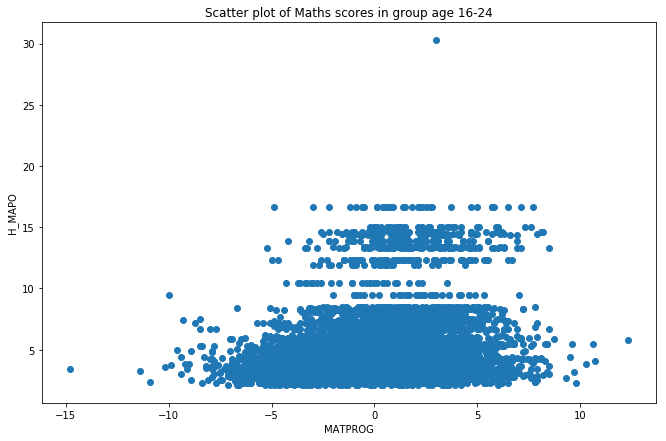

In [570]:
# plot the current data frame

plt.subplots(figsize=(11, 7))

plt.scatter(qtrs_df['MATPROG'],
            qtrs_df['H_MAPO'])

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('MATPROG')
plt.ylabel('H_MAPO')

plt.title('Scatter plot of Maths scores in group age 16-24')
plt.show()

Graph shows similar distribution of H_MAPO and maths scores to writing scores for the same age group

In [571]:
# create a pivot table indexing local authority

ga_m_df = qtrs_df.pivot_table(qtrs_df, index=['LA'], aggfunc=np.mean)
ga_m_df.head()

,H_MAPO,MATPROG
LA,,
Adur,2.7104,-0.433333
Allerdale,2.9845,-1.232000
Amber Valley,3.1504,-0.226667
Arun,2.3072,-1.785714
Ashfield,2.6650,-0.484375


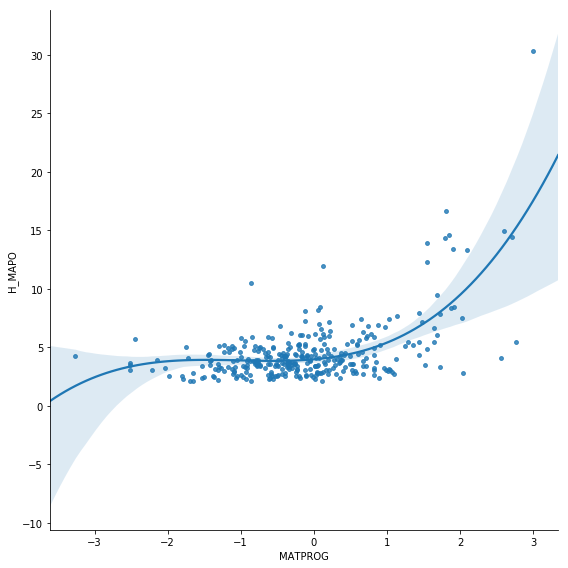

In [572]:
# produce a polynomial regression for scores in reading and H_MAPO group

sns.lmplot(x='MATPROG', y='H_MAPO', data=ga_m_df, scatter_kws={'s':15}, order=3, size=8)
plt.show()

Graph shows that an increase of maths scores from around 1 is associated with an increase of H_MAPO percentage group.

In [573]:
# Create an instance of the clusterer with k=2
#kmeans2 = cluster.KMeans(n_clusters=2, n_init=50, max_iter=500, precompute_distances=True, n_jobs=-1)
kmeans3 = cluster.KMeans(n_clusters=3)

In [574]:
clusteringData_ga_m_df = ga_m_df[['MATPROG', 'H_MAPO']]
clusteringData_ga_m_df.head()

,MATPROG,H_MAPO
LA,,
Adur,-0.433333,2.7104
Allerdale,-1.232000,2.9845
Amber Valley,-0.226667,3.1504
Arun,-1.785714,2.3072
Ashfield,-0.484375,2.6650


In [575]:
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_ga_m_df_clust = kmeans3.fit(clusteringData_ga_m_df)

In [576]:
assignedClusters_ga_m_df_clust.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 1, 1, 0, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1,
       2, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 2, 1,

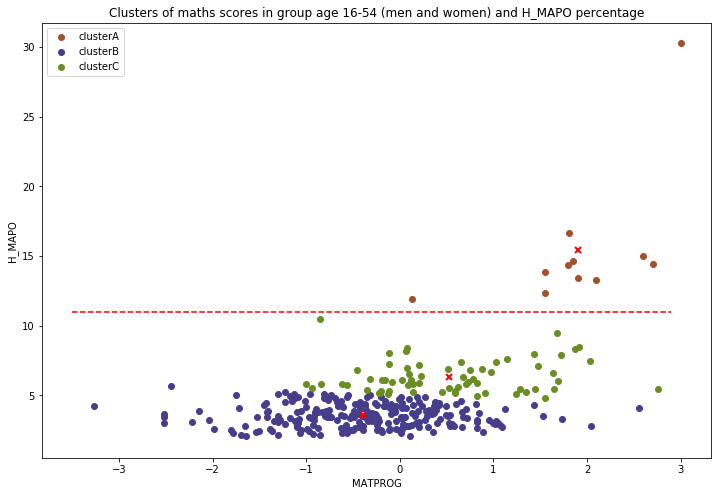

In [577]:
plt.subplots(figsize=(12, 8))

# Plot the data points which in the cluster labelled 'ClusterA'
plt.scatter(ga_m_df['MATPROG'][assignedClusters_ga_m_df_clust.labels_==0],
            ga_m_df['H_MAPO'][assignedClusters_ga_m_df_clust.labels_==0],
            color='sienna', marker='o', label='clusterA')

# Plot the data points which in the cluster labelled 'ClusterB'
plt.scatter(ga_m_df['MATPROG'][assignedClusters_ga_m_df_clust.labels_==1],
            ga_m_df['H_MAPO'][assignedClusters_ga_m_df_clust.labels_==1],
            color='darkslateblue', marker='o', label='clusterB')


# Plot the data points which in the cluster labelled 'ClusterC'
plt.scatter(ga_m_df['MATPROG'][assignedClusters_ga_m_df_clust.labels_==2],
            ga_m_df['H_MAPO'][assignedClusters_ga_m_df_clust.labels_==2],
            color='olivedrab', marker='o', label='clusterC')



# Plot each of the centroids:
for (cx, cy) in assignedClusters_ga_m_df_clust.cluster_centers_:
    plt.plot(cx, cy, color='r', marker='x', mew=2)

plt.legend()


plt.xlabel('MATPROG')
plt.ylabel('H_MAPO')

plt.title('Clusters of maths scores in group age 16-54 (men and women) and H_MAPO percentage')

plt.plot([-3.5,2.9],[11,11], "r--")
plt.show()

The graph shows that H_MAPO accounting for 11% and more has a positive values on average

### Maths in group age 25-49<a name="Maths_MF25-49All"></a>
[top](#top)

In [578]:
# filter SAE to select only male/female in all group 16 - 24

fgrff = ['MF25-49All']
qt_dff = filterGroups(qt_df, fgrff, 'SAE')

qtrs_df = qt_dff[['SAE','LA', 'MATPROG', 'H_MAPO']]
qtrs_df[['MATPROG', 'H_MAPO']] = qtrs_df[['MATPROG', 'H_MAPO']].astype(float)

qtrs_df.head(6)

12544  rows filtered out of  37649


,SAE,LA,MATPROG,H_MAPO
1,MF25-49All,City of London,3.0,42.7765
4,MF25-49All,Camden,0.3,28.8754
7,MF25-49All,Camden,2.3,28.8754
10,MF25-49All,Camden,6.0,28.8754
13,MF25-49All,Camden,2.7,28.8754
16,MF25-49All,Camden,0.0,28.8754


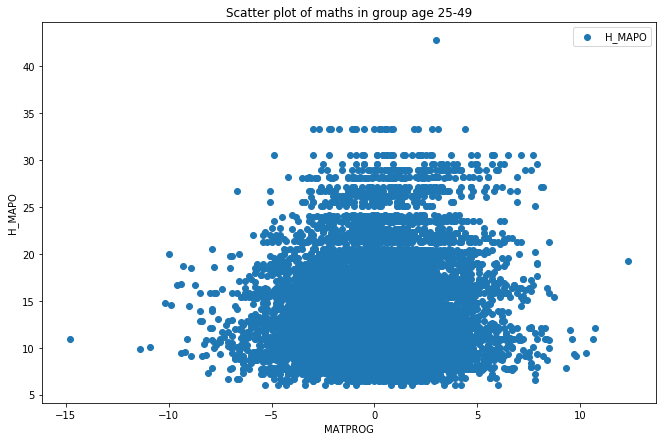

In [579]:
# plot the current data frame

plt.subplots(figsize=(11, 7))

plt.scatter(qtrs_df['MATPROG'],
            qtrs_df['H_MAPO'])

plt.legend()

plt.xlabel('MATPROG')
plt.ylabel('H_MAPO')

plt.title('Scatter plot of maths in group age 25-49')
plt.show()

In [580]:
# create a pivot table indexing local authority

gb_m_df = qtrs_df.pivot_table(qtrs_df, index=['LA'], aggfunc=np.mean)
gb_m_df.head()

,H_MAPO,MATPROG
LA,,
Adur,11.3666,-0.433333
Allerdale,9.3810,-1.232000
Amber Valley,12.3237,-0.226667
Arun,10.2697,-1.785714
Ashfield,8.6657,-0.484375


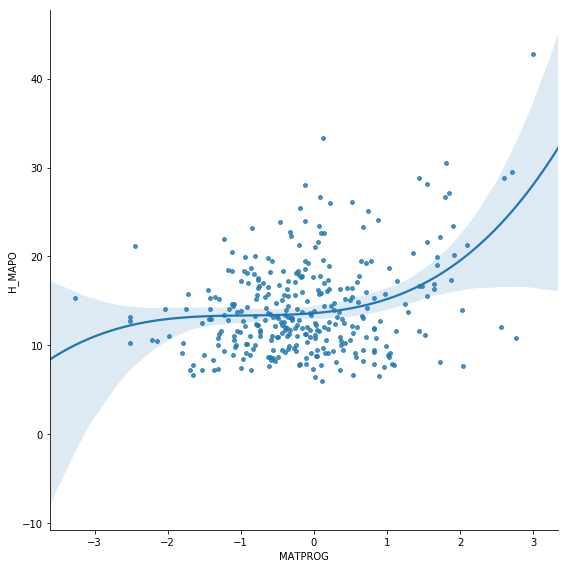

In [581]:
# produce a polynomial regression for scores in reading and H_MAPO group

sns.lmplot(x='MATPROG', y='H_MAPO', data=gb_m_df, scatter_kws={'s':15}, order=3, size=8)
plt.show()

Graphs above show wide distribution in all percentage groups. Thefore I'll try to use different initial values and I shall increase the number of clusters in order to capture maths scores for 28.5%+ group.

In [582]:
initialCentroids_df = pd.DataFrame({'MATPROG':[-0.5, 0.0, 0.5, 1.5, 2.0], 'H_MAPO':[10.0, 16.0, 21.0, 15.0, 30.0]}, columns=['MATPROG', 'H_MAPO'])
initialCentroids_df

,MATPROG,H_MAPO
0,-0.5,10.0
1,0.0,16.0
2,0.5,21.0
3,1.5,15.0
4,2.0,30.0


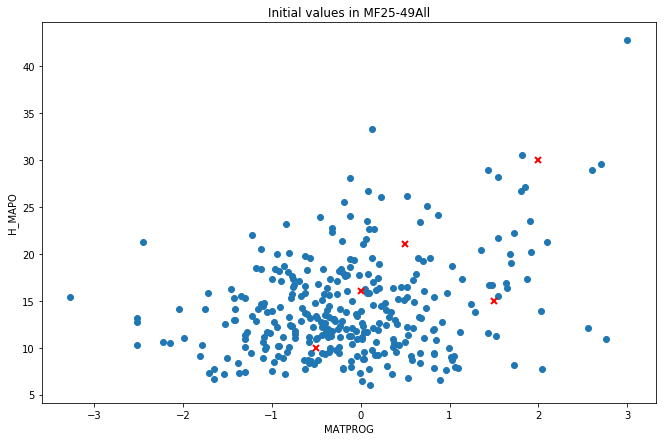

In [583]:
# check the initial values

plt.subplots(figsize=(11, 7))

plt.scatter(gb_m_df['MATPROG'],
            gb_m_df['H_MAPO'])

plt.xlabel('MATPROG')
plt.ylabel('H_MAPO')

plt.title('Initial values in MF25-49All')

# Plot each of the centroids:
for i in initialCentroids_df.index:
    plt.plot(initialCentroids_df.loc[i]['MATPROG'],
             initialCentroids_df.loc[i]['H_MAPO'],
             color='r', marker='x', mew=2)
    
plt.show()

In [584]:
#Create an instance of the clusterer with k=2
#kmeans2 = cluster.KMeans(n_clusters=2, n_init=50, max_iter=500, precompute_distances=True, n_jobs=-1)
kmeans5 = cluster.KMeans(n_clusters=5, init=initialCentroids_df)

In [585]:
clusteringData_gb_m_df = gb_m_df[['MATPROG', 'H_MAPO']]
clusteringData_gb_m_df.head()

,MATPROG,H_MAPO
LA,,
Adur,-0.433333,11.3666
Allerdale,-1.232000,9.3810
Amber Valley,-0.226667,12.3237
Arun,-1.785714,10.2697
Ashfield,-0.484375,8.6657


In [586]:
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_gb_m_df_clust = kmeans5.fit(clusteringData_gb_m_df)

C:\Users\patry\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [587]:
assignedClusters_gb_m_df_clust.labels_

array([3, 0, 3, 0, 0, 3, 1, 3, 0, 2, 0, 0, 3, 2, 0, 1, 3, 3, 3, 3, 0, 0,
       0, 3, 0, 3, 1, 3, 3, 0, 3, 2, 1, 1, 3, 2, 1, 3, 1, 0, 3, 3, 4, 4,
       0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 3, 3, 4, 3, 3, 0, 0, 1,
       0, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 0, 0, 0, 1, 1, 3, 1, 1, 2, 0, 3,
       3, 3, 0, 1, 0, 4, 3, 1, 2, 3, 1, 1, 0, 0, 0, 1, 3, 3, 3, 0, 0, 0,
       1, 2, 1, 0, 1, 4, 1, 1, 0, 1, 2, 2, 0, 0, 3, 3, 0, 1, 3, 1, 3, 1,
       1, 1, 0, 3, 0, 4, 4, 3, 0, 0, 2, 3, 0, 2, 3, 1, 0, 3, 1, 1, 0, 3,
       0, 3, 3, 1, 1, 0, 0, 3, 3, 2, 3, 3, 1, 0, 1, 2, 3, 3, 1, 3, 3, 0,
       3, 3, 0, 2, 3, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 0, 1, 0, 4, 0, 3, 0,
       3, 3, 3, 0, 2, 1, 0, 2, 1, 4, 3, 0, 3, 3, 3, 0, 1, 2, 2, 3, 1, 3,
       3, 0, 0, 0, 3, 1, 2, 1, 0, 3, 3, 1, 2, 4, 3, 1, 3, 0, 3, 3, 3, 1,
       2, 3, 3, 3, 0, 3, 3, 2, 1, 4, 3, 0, 1, 3, 3, 1, 0, 0, 1, 1, 3, 0,
       2, 1, 0, 3, 0, 0, 1, 3, 3, 3, 0, 1, 1, 0, 2, 0, 1, 0, 0, 2, 2, 1,
       1, 2, 0, 0, 3, 4, 1, 2, 1, 0, 2, 3, 0, 1, 2,

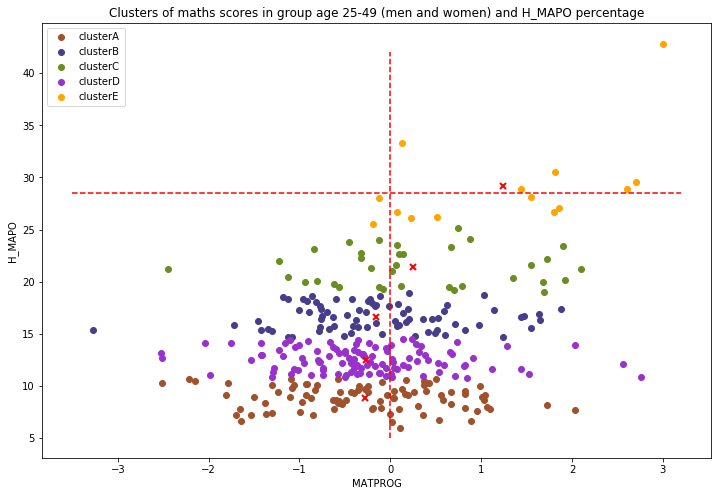

In [588]:
plt.subplots(figsize=(12, 8))

# Plot the data points which in the cluster labelled 'ClusterA'
plt.scatter(gb_m_df['MATPROG'][assignedClusters_gb_m_df_clust.labels_==0],
            gb_m_df['H_MAPO'][assignedClusters_gb_m_df_clust.labels_==0],
            color='sienna', marker='o', label='clusterA')

# Plot the data points which in the cluster labelled 'ClusterB'
plt.scatter(gb_m_df['MATPROG'][assignedClusters_gb_m_df_clust.labels_==1],
            gb_m_df['H_MAPO'][assignedClusters_gb_m_df_clust.labels_==1],
            color='darkslateblue', marker='o', label='clusterB')

#Plot the data points which in the cluster labelled 'ClusterC'
plt.scatter(gb_m_df['MATPROG'][assignedClusters_gb_m_df_clust.labels_==2],
            gb_m_df['H_MAPO'][assignedClusters_gb_m_df_clust.labels_==2],
            color='olivedrab', marker='o', label='clusterC')
        
#Plot the data points which in the cluster labelled 'ClusterC'
plt.scatter(gb_m_df['MATPROG'][assignedClusters_gb_m_df_clust.labels_==3],
            gb_m_df['H_MAPO'][assignedClusters_gb_m_df_clust.labels_==3],
            color='darkorchid', marker='o', label='clusterD')

#Plot the data points which in the cluster labelled 'ClusterC'
plt.scatter(gb_m_df['MATPROG'][assignedClusters_gb_m_df_clust.labels_==4],
            gb_m_df['H_MAPO'][assignedClusters_gb_m_df_clust.labels_==4],
            color='orange', marker='o', label='clusterE')
        

# Plot each of the centroids:
for (cx, cy) in assignedClusters_gb_m_df_clust.cluster_centers_:
    plt.plot(cx, cy, color='r', marker='x', mew=2)

plt.legend()


plt.xlabel('MATPROG')
plt.ylabel('H_MAPO')

plt.title('Clusters of maths scores in group age 25-49 (men and women) and H_MAPO percentage')
plt.plot([-3.5,3.2],[28.5,28.5], "r--")
plt.plot([0.0,0.0],[5.0,42.0], "r--")

plt.show()

The graph shows similar results to writing scores for the same group, where positive writing scores are widely distributed in clusterA, clusterD and clusterB. Changing number of clusters and initial centroids did not help with capturing positive maths scores for the 28.5%+ group. It means that the data points are still too widely distributed even for the higher percentage group.

I added lines to mark the desired group.

### Maths in group age 50-64<a name="Maths_MF50-64All"></a>
[top](#top)

In [589]:
# filter SAE to select only male/female in all group 16 - 24

fgrff = ['MF50-64All']
qt_dff = filterGroups(qt_df, fgrff, 'SAE')

qtrs_df = qt_dff[['SAE','LA', 'MATPROG', 'H_MAPO']]
qtrs_df[['MATPROG', 'H_MAPO']] = qtrs_df[['MATPROG', 'H_MAPO']].astype(float)

qtrs_df.head(6)

12544  rows filtered out of  37649


,SAE,LA,MATPROG,H_MAPO
2,MF50-64All,City of London,3.0,37.8855
5,MF50-64All,Camden,0.3,19.3776
8,MF50-64All,Camden,2.3,19.3776
11,MF50-64All,Camden,6.0,19.3776
14,MF50-64All,Camden,2.7,19.3776
17,MF50-64All,Camden,0.0,19.3776


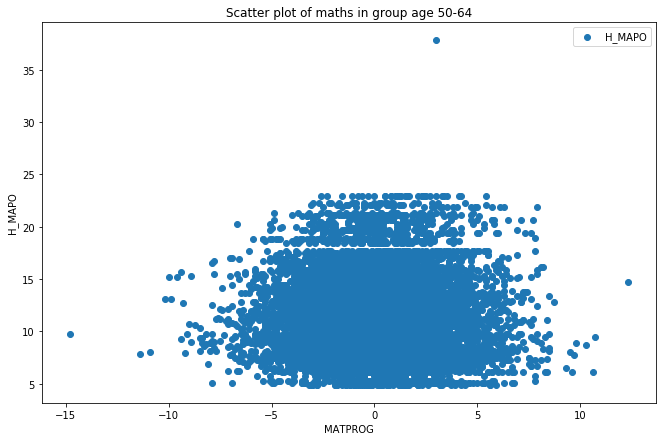

In [590]:
# plot the current data frame

plt.subplots(figsize=(11, 7))

plt.scatter(qtrs_df['MATPROG'],
            qtrs_df['H_MAPO'])

plt.legend()

plt.xlabel('MATPROG')
plt.ylabel('H_MAPO')

plt.title('Scatter plot of maths in group age 50-64')
plt.show()

In [591]:
# create a pivot table indexing local authority

gc_m_df = qtrs_df.pivot_table(qtrs_df, index=['LA'], aggfunc=np.mean)
gc_m_df.head()

,H_MAPO,MATPROG
LA,,
Adur,9.4876,-0.433333
Allerdale,9.2943,-1.232000
Amber Valley,10.4004,-0.226667
Arun,11.2314,-1.785714
Ashfield,5.7867,-0.484375


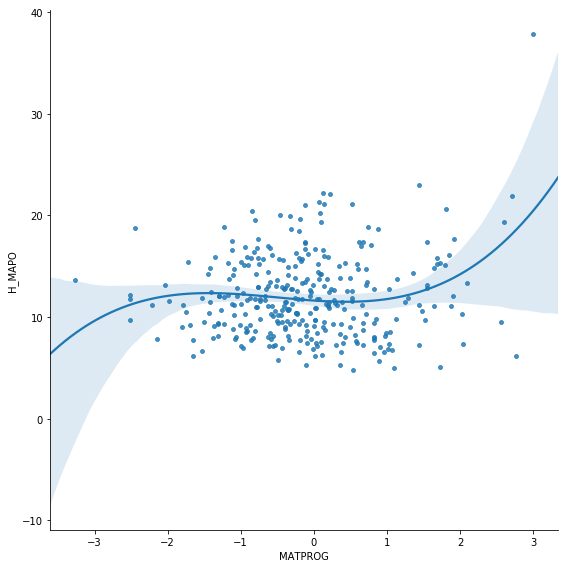

In [592]:
# produce a polynomial regression for scores in reading and H_MAPO group

sns.lmplot(x='MATPROG', y='H_MAPO', data=gc_m_df, scatter_kws={'s':15}, order=3, size=8)
plt.show()

In [593]:
# Create an instance of the clusterer with k=2
#kmeans2 = cluster.KMeans(n_clusters=2, n_init=50, max_iter=500, precompute_distances=True, n_jobs=-1)
kmeans4 = cluster.KMeans(n_clusters=4)

In [594]:
clusteringData_gc_m_df = gc_m_df[['MATPROG', 'H_MAPO']]
clusteringData_gc_m_df.head()

,MATPROG,H_MAPO
LA,,
Adur,-0.433333,9.4876
Allerdale,-1.232000,9.2943
Amber Valley,-0.226667,10.4004
Arun,-1.785714,11.2314
Ashfield,-0.484375,5.7867


In [595]:
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_gc_m_df_clust = kmeans4.fit(clusteringData_gc_m_df)

In [596]:
assignedClusters_gc_m_df_clust.labels_

array([1, 1, 2, 2, 1, 2, 0, 2, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 0, 1, 2, 1, 2, 0, 0, 2, 2, 0, 0, 1, 2, 1, 2, 2, 3, 3,
       1, 2, 1, 1, 2, 2, 0, 0, 2, 0, 0, 1, 0, 3, 2, 2, 3, 2, 1, 1, 1, 0,
       1, 1, 2, 1, 2, 0, 1, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 0, 0, 0, 1, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 0, 1, 2, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1,
       2, 3, 2, 1, 0, 0, 0, 0, 1, 0, 0, 3, 1, 1, 2, 1, 2, 0, 2, 2, 2, 0,
       2, 0, 1, 1, 1, 0, 3, 2, 1, 1, 0, 2, 1, 2, 2, 2, 1, 0, 2, 0, 1, 1,
       1, 2, 2, 0, 1, 1, 1, 2, 2, 0, 2, 2, 0, 1, 0, 3, 2, 2, 2, 2, 1, 1,
       2, 2, 1, 0, 2, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 3, 1, 1, 1,
       2, 2, 2, 2, 0, 2, 1, 0, 0, 3, 2, 1, 2, 2, 2, 1, 2, 0, 3, 2, 0, 2,
       1, 1, 1, 2, 2, 2, 0, 2, 1, 2, 1, 0, 3, 3, 2, 2, 2, 1, 2, 2, 2, 0,
       3, 2, 2, 2, 1, 1, 2, 2, 2, 3, 2, 1, 0, 2, 2, 0, 1, 1, 0, 0, 2, 1,
       3, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 2, 0, 0,
       0, 3, 1, 1, 1, 0, 2, 0, 2, 1, 3, 0, 1, 0, 0,

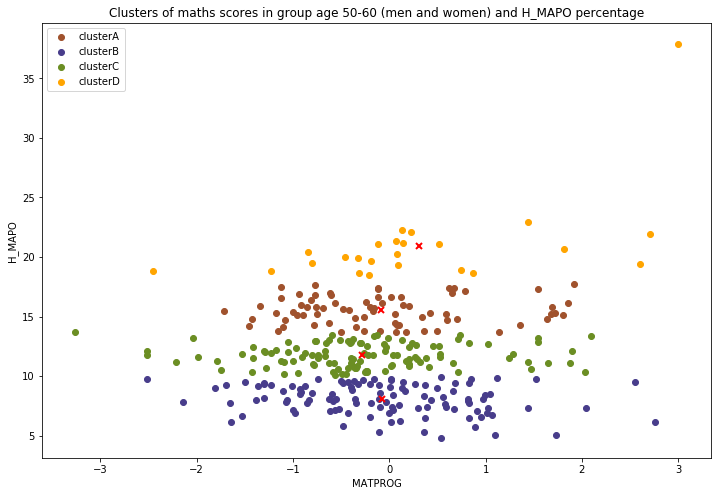

In [597]:
plt.subplots(figsize=(12, 8))

# Plot the data points which in the cluster labelled 'ClusterA'
plt.scatter(gc_m_df['MATPROG'][assignedClusters_gc_m_df_clust.labels_==0],
            gc_m_df['H_MAPO'][assignedClusters_gc_m_df_clust.labels_==0],
            color='sienna', marker='o', label='clusterA')

# Plot the data points which in the cluster labelled 'ClusterB'
plt.scatter(gc_m_df['MATPROG'][assignedClusters_gc_m_df_clust.labels_==1],
            gc_m_df['H_MAPO'][assignedClusters_gc_m_df_clust.labels_==1],
            color='darkslateblue', marker='o', label='clusterB')


# Plot the data points which in the cluster labelled 'ClusterC'
plt.scatter(gc_m_df['MATPROG'][assignedClusters_gc_m_df_clust.labels_==2],
            gc_m_df['H_MAPO'][assignedClusters_gc_m_df_clust.labels_==2],
            color='olivedrab', marker='o', label='clusterC')


# Plot the data points which in the cluster labelled 'ClusterD'
plt.scatter(gc_m_df['MATPROG'][assignedClusters_gc_m_df_clust.labels_==3],
            gc_m_df['H_MAPO'][assignedClusters_gc_m_df_clust.labels_==3],
            color='orange', marker='o', label='clusterD')



# Plot each of the centroids:
for (cx, cy) in assignedClusters_gc_m_df_clust.cluster_centers_:
    plt.plot(cx, cy, color='r', marker='x', mew=2)

plt.legend()


plt.xlabel('MATPROG')
plt.ylabel('H_MAPO')

plt.title('Clusters of maths scores in group age 50-60 (men and women) and H_MAPO percentage')

plt.show()

The graph shows that it is almost impossible to cluster positive writing scores in any H_MAPO percentage group for MF50-60 age group. This is due to wide distribution of positive and negative maths scores in each percentage group with similar standard deviation (checked visually) in cluster C, A and B

#### End of analysis
[top](#top)

In [598]:
# end runtime
endT = time.time()
rt = round(endT - startT, 2)

In [599]:
print(rt, "seconds runtime")

15.44 seconds runtime
